In [1]:
import numpy as np
from random import choice, sample
from scipy.special import comb
import networkx as nx
import matplotlib.pyplot as plt
import time as tt

# Wright Fisher Model

In [2]:
#N := population size
#t := t generations
def wrightfisher_model(N,t): #Wright-Fisher model haploid population without mutation, selection, fitness
  genealogy = [np.array([i]) for i in range(1,N+1)] #Creates initial Generation G_0 with N individuals
  for gen_step in range(t): #t generation steps
    nextG = [ choice(genealogy) for individual in range(N)]    #draw N elements with replacement each generation

    nextG_sorted = sorted(nextG, key=lambda x: x[0])  #sort list by first index

    for j in range(N):                                #insert new index for all arrays to label them as new individuals
      nextG_sorted[j] = np.insert(nextG_sorted[j], 0, j+1)

    genealogy = nextG_sorted #update genealogy
  return genealogy

def wrightfisher_unsorted(N,t):
  genealogy = [np.array([i]) for i in range(1,N+1)] #Creates initial Generation G_0 with N individuals
  for gen_step in range(t): #t generation steps
    nextG = [ choice(genealogy) for individual in range(N)]    #draw N elements with replacement each generation

    for j in range(N):                                #insert new index for all arrays to label them as new individuals
      nextG[j] = np.insert(nextG[j], 0, j+1)

    genealogy = nextG #update genealogy
  return genealogy

Test Speed of Wright Fisher sorted/unsorted

In [ ]:
model=wrightfisher_model(1000,3000) #model with 1000 Individuals, 2000 Generations

In [ ]:
start=tt.time()
unsorted = wrightfisher_unsorted(1000,2000)
end=tt.time()
print(end-start)
start1=tt.time()
unsorted = wrightfisher_model(1000,2000)
end1=tt.time()
print(end1-start1)

33.36370539665222
34.5278856754303


#Most Recent Common Ancestor

In [3]:
def wrightfisher_mrca(n,model,maxiter=50,test=False): #calculate mrca of given population and n samples in most recent generation
  time_len = len(model[0]) #time length by generations
  if n>=len(model)-1:
    print("Invalid sample size")
    return [0,0,[0]]
  elif time_len <= 1:
    print("There are just 1-2 generations, use model with more generations")
    return [0,0,[0]]
  if test: #for the test function
    maxiter=1
  realiter=0 #for small models the sample might not necessarily give the mrca
  while realiter<maxiter:
    g=0 #how many generations does it take to go back until mrca
    realiter += 1
    liste = sample(model, n)   #draw n different samples

    for s in range(1,time_len): #check generation until mrca
      g+=1
      break_inner_loop=False
      for j in range(1,n): #check all individuals if they share common ancestor in generation t-s backwards
        if liste[0][s] != liste[j][s]: #if not break, check next gen k+1
          break_inner_loop=True
          break
      if break_inner_loop == False: #if no break, mrca found in generation g=k
        return [g,realiter,liste]
  if test:
    #print(f"iteration exceeded sample {n}")
    return [g,1,liste]
  print(f"No recent common ancestor found for samplesize {n}, max iteration {maxiter} exceeded, use less samplesize, or bigger population")
  return [0,0,[0]]

In [ ]:
wf_backwards_mrca = wrightfisher_mrca(5,model,maxiter=100,test=True);wf_backwards_mrca

[2470,
 1,
 [array([881, 863, 878, ..., 827, 810, 810]),
  array([489, 477, 508, ..., 827, 810, 810]),
  array([225, 224, 230, ..., 827, 810, 810]),
  array([289, 290, 298, ..., 827, 810, 810]),
  array([820, 809, 829, ..., 827, 810, 810])]]

In [ ]:
wf_backwards_mrca[2][0][0]

881

In [ ]:
n=list(range(30));
print(3/5,14/16,29/31)
for k in n:
  for j in range(4):
    wf_backwards_mrca = wrightfisher_mrca(k,model,maxiter=100,test=True)
    print(f"It took {wf_backwards_mrca[0]} generations to find the mrca for the sample {k}. It needed {wf_backwards_mrca[1]} iterations")
  print(" ")
  print(" ")

0.6 0.875 0.9354838709677419
It took 1 generations to find the mrca for the sample 0. It needed 1 iterations
It took 1 generations to find the mrca for the sample 0. It needed 1 iterations
It took 1 generations to find the mrca for the sample 0. It needed 1 iterations
It took 1 generations to find the mrca for the sample 0. It needed 1 iterations
 
 
It took 1 generations to find the mrca for the sample 1. It needed 1 iterations
It took 1 generations to find the mrca for the sample 1. It needed 1 iterations
It took 1 generations to find the mrca for the sample 1. It needed 1 iterations
It took 1 generations to find the mrca for the sample 1. It needed 1 iterations
 
 
It took 120 generations to find the mrca for the sample 2. It needed 1 iterations
It took 2470 generations to find the mrca for the sample 2. It needed 1 iterations
It took 365 generations to find the mrca for the sample 2. It needed 1 iterations
It took 2470 generations to find the mrca for the sample 2. It needed 1 iter

# Random Exponential Samples for the n-coalescence

In [4]:
#n=samplesize, m=precision
#get exponential distributed sample points, each point represents the time needed for a coalescence event to take place
def expo_samples(n,N,toggle = True,m=1000): #toggle True to scale time by N generations
  liste = range(m)
  randomnumbers = [choice(liste) for i in range(n)] #draw n random numbers from 0 to m-1
  randomTimeLengths=[]
  for i in range(2,n+1): #from 2 to n coalescence events
    binom=comb(i, 2, exact=True)
    if randomnumbers[i-2]+1 == m: #avoid problems with infinity
      time = (-1/binom * np.log( 1/m) +1 /binom)
    else:
      time =(1/binom * np.log( (m - (randomnumbers[i-2]+1))/m) -1/binom) * ( m - (randomnumbers[i-2]+1)) + (-1/binom * np.log( (m - randomnumbers[i-2])/m) +1 /binom ) * ( m - randomnumbers[i-2] )
    if toggle:
      randomTimeLengths.insert(0,time*N)
    else:
      randomTimeLengths.insert(0,time)
  return randomTimeLengths

#exponential distributed samples with numpy libary
def expo_numpy(n,N,toggle=True):
  exonentialnumbers=np.array([])
  if toggle: #with scale N or without
    for i in range(2,n+1):
      exonentialnumbers=np.insert(exonentialnumbers,0,np.random.exponential(1/comb(i, 2, exact=True), 1)*N)
  else:
    for i in range(2,n+1):
      exonentialnumbers=np.append(exonentialnumbers,0,np.random.exponential(1/comb(i, 2, exact=True), 1))
  return exonentialnumbers.tolist()

Testing speed of my own algorithm and from the numpy library

In [ ]:
start1= tt.time()
durchlauf=10000
parameter1=0
sample=8
N=1000
for i in range(durchlauf):
  parameter1+=sum(expo_samples(sample,N,m=1000000))
parameter1/=durchlauf;print(parameter1)
end1=tt.time()
print(end1-start1)

1746.4738527685881
0.34825658798217773


In [ ]:
#numpy libary
start2= tt.time()
parameter2=0
for i in range(durchlauf):
  parameter2+=sum(expo_numpy(sample,N))
parameter2/=durchlauf;print(parameter2)
end2=tt.time()
print(end2-start2)

1761.0467463793452
1.212470293045044


It looks like my own algorithm is almost 4 times faster.

Test excpactation bias and variance of the newly generated function expo_samples

In [ ]:
def test_expo_samples_bias(n,i,m=1000000): #test, if the taken generator is unbaised
  liste = range(m)
  randomnumbers = [choice(liste) for i in range(n)] #draw n random numbers from 0 to m-1
  randomtimlengths=[]
  binom=comb(i, 2, exact=True)
  for k in range(len(randomnumbers)): #calculate time interval for every sample point and take conditional expectation to get samples, iid RV exp(binom(i,2)) distributed
    if randomnumbers[k]+1 == m:
      time = (-1/binom * np.log( 1/m) +1 /binom )
    else:
      time =(1/binom * np.log( (m - (randomnumbers[k]+1))/m) -1/binom) * ( m - (randomnumbers[k]+1)) + (-1/binom * np.log( (m - randomnumbers[k])/m) +1 /binom ) * ( m - randomnumbers[k] )
    randomtimlengths.insert(0,time)
  expectation= sum(randomtimlengths)/n
  return [sum(randomtimlengths)/n,1/binom, 1/(n-1)*sum((randomtimlengths[k]-expectation)**2 for k in range(n)), 1/(binom**2)]


In [ ]:
explist = test_expo_samples_bias(10000,8,m=1000000);print(explist);print(abs(explist[0]-explist[1]),abs(explist[2]-explist[3]))

[0.03521134562062092, 0.03571428571428571, 0.001258402351119557, 0.0012755102040816326]
0.0005029400936647915 1.7107852962075466e-05


Bias results look good, thus we will continue using the new algorithm instead of a library

In [ ]:
random_coalesce_times = expo_samples(8,1000,m=100000);print(f"It took {sum(random_coalesce_times)} generations, until the last coalescence event");random_coalesce_times

It took 793.2024366814403 generations, until the last coalescence event


[25.907576470217464,
 29.216701252153143,
 1.7648213552092784,
 44.14783706488379,
 97.40156239786302,
 293.17900051682955,
 301.58493762428407]

In [ ]:
for j in range(2,21):
  aa=0
  for k in range(2000):
    aa+=sum(expo_samples(j,1000,m=1000000))
  print(f"{aa/2000} for {j} samples")

1072.4485845974018 for 2 samples
1338.1722103139475 for 3 samples
1500.4587142720754 for 4 samples
1612.45827477743 for 5 samples
1707.4115010611597 for 6 samples
1751.1356969704887 for 7 samples
1753.623921651252 for 8 samples
1768.4857206389538 for 9 samples
1800.7618158371172 for 10 samples
1809.5977195232445 for 11 samples
1824.0675762565113 for 12 samples
1860.8344582967393 for 13 samples
1835.956224301874 for 14 samples
1876.507382720599 for 15 samples
1890.5641526925533 for 16 samples
1882.9861691458752 for 17 samples
1907.9255608369283 for 18 samples
1904.0801160960953 for 19 samples
1964.973221501883 for 20 samples


# Test Functions

Testing how coalescence and wright fisher corelate

In [ ]:
def test_wf_model(population, samplesize, test_runs=20,test=False,toggle=False,add_run=10): #toggle True may safe costly calculations, if we make more test runs on the same model
  lengthh=len(samplesize)
  if toggle:
    bound=add_run
  else:
    bound=1

  wf_test_results=[0 for k in range(lengthh)]
  coales_test_result=[0 for k in range(lengthh)]
  controll=[test_runs*bound for k in range(lengthh)] #one test is expensive, so we test different sample sizes

  for i in range(test_runs):
    model=wrightfisher_model(population,int(3*population))
    k=0
    while k < bound:
      for index in range(lengthh):
        backwards=wrightfisher_mrca(samplesize[index],model, maxiter=50, test=test)
        wf_test_results[index]+=backwards[0] #add number of generations until mrca
        if backwards[0] > 0:
          coales_test_result[index]+=sum(expo_samples(samplesize[index],population,m=1000000)) #if mrca found, then also add expo_samples, otherwise wrong calculation
        else:
          controll[index]-=1
      k+=1
  return [ [wf_test_results[index]/controll[index], coales_test_result[index]/controll[index]] for index in range(lengthh) ]

In [ ]:
population=10;samplesize=[2,3,4,5,6]
results = test_wf_model(population, samplesize, test_runs=20,test=True)
for index in range(len(samplesize)):
  print(f"WrghtFisher with population N={population}, samplesize n={samplesize[index]}, it takes {round(results[index][0],2)} generations, coales yields {round(results[index][1],2)} generations until mrca, difference {round(results[index][0]/results[index][1],2)}")

iteration exceeded sample 4
iteration exceeded sample 5
iteration exceeded sample 6
iteration exceeded sample 3
iteration exceeded sample 4
iteration exceeded sample 5
iteration exceeded sample 6
WrghtFisher with population N=10, samplesize n=2, it takes 8.6 generations, coales yields 6.08 generations until mrca, difference 1.42
WrghtFisher with population N=10, samplesize n=3, it takes 11.55 generations, coales yields 14.23 generations until mrca, difference 0.81
WrghtFisher with population N=10, samplesize n=4, it takes 13.6 generations, coales yields 13.64 generations until mrca, difference 1.0
WrghtFisher with population N=10, samplesize n=5, it takes 13.85 generations, coales yields 18.55 generations until mrca, difference 0.75
WrghtFisher with population N=10, samplesize n=6, it takes 13.65 generations, coales yields 17.47 generations until mrca, difference 0.78


In [ ]:
population=100;samplesize=[2,3,4,5,6,7,8,9,10,11,12,13]
results = test_wf_model(population, samplesize, test_runs=20,test = True)
for index in range(len(samplesize)):
  print(f"WrghtFisher with population N={population}, samplesize n={samplesize[index]}, it takes {round(results[index][0],2)} generations, coales yields {round(results[index][1],2)} generations until mrca, difference {round(results[index][0]/results[index][1],2)}")


WrghtFisher with population N=100, samplesize n=2, it takes 94.15 generations, coales yields 68.0 generations until mrca, difference 1.38
WrghtFisher with population N=100, samplesize n=3, it takes 130.5 generations, coales yields 143.08 generations until mrca, difference 0.91
WrghtFisher with population N=100, samplesize n=4, it takes 163.8 generations, coales yields 120.18 generations until mrca, difference 1.36
WrghtFisher with population N=100, samplesize n=5, it takes 160.85 generations, coales yields 119.11 generations until mrca, difference 1.35
WrghtFisher with population N=100, samplesize n=6, it takes 135.9 generations, coales yields 152.97 generations until mrca, difference 0.89
WrghtFisher with population N=100, samplesize n=7, it takes 156.7 generations, coales yields 202.89 generations until mrca, difference 0.77
WrghtFisher with population N=100, samplesize n=8, it takes 155.65 generations, coales yields 207.4 generations until mrca, difference 0.75
WrghtFisher with popu

In [ ]:
population=1000;samplesize=[2,3,4,5,6,8,9,10,11,12,13]
results = test_wf_model(population, samplesize, test_runs=10, test=True)
for index in range(len(samplesize)):
  print(f"WrghtFisher with population N={population}, samplesize n={samplesize[index]}, it takes {round(results[index][0],2)} generations, coales yields {round(results[index][1],2)} generations until mrca, difference {round(results[index][0]/results[index][1],2)}")

WrghtFisher with population N=1000, samplesize n=2, it takes 1441.8 generations, coales yields 1434.58 generations until mrca, difference 1.01
WrghtFisher with population N=1000, samplesize n=3, it takes 1291.8 generations, coales yields 1097.47 generations until mrca, difference 1.18
WrghtFisher with population N=1000, samplesize n=4, it takes 1913.8 generations, coales yields 2161.91 generations until mrca, difference 0.89
WrghtFisher with population N=1000, samplesize n=5, it takes 1565.8 generations, coales yields 965.57 generations until mrca, difference 1.62
WrghtFisher with population N=1000, samplesize n=6, it takes 2027.2 generations, coales yields 1634.0 generations until mrca, difference 1.24
WrghtFisher with population N=1000, samplesize n=8, it takes 1817.7 generations, coales yields 2015.83 generations until mrca, difference 0.9
WrghtFisher with population N=1000, samplesize n=9, it takes 2041.8 generations, coales yields 1730.99 generations until mrca, difference 1.18
Wr

We can see, that with  N=1000, WF and coalescence differ quite a lot. Stepping up the size N, and trying to run the function more often and calculating the mean seems to be an impossible task with the current and even better engines. Calculating the ancestor tree of a WF population is extremly costly. Thus it shows the cumputational advantages of the coalescence, where just n expo distributed sample times are calculated.

# Visualisation

In [5]:
def draw_graph(G,xaxis=10,yaxis=12,title="Wright Fisher Genealogy"):
    pos = {(x, y): (x, y) for x, y in G.nodes()}  # Positionen so, dass (0, 0) unten links ist
    plt.figure(figsize=(int(xaxis), int(yaxis)))
    nx.draw(G, pos=pos, node_size=0.1)
    plt.title(title)
    plt.show()

def graph_back_gen_wf(model): #Visualises the whole geanology backwards of a wright fisher Population
  G = nx.Graph()
  #for i in range(t):
   # for j in range(N):
    #  G.add_node((j, i))
  time=len(model[0])
  for individual in model:
    for t in range(time-1):
      G.add_edge( (individual[t],t) , (individual[t+1],t+1)) #adds edge from child to parent
      if G.degree[ (individual[t+1],t+1)] ==2:
        break
  return G

def graph_sample_back_gen_wf(mrca,model): #
  backwards=mrca #wrightfisher_mrca(n,model,test=True)
  individuals=len(backwards[2])
  time=backwards[0]
  G = nx.Graph()
  for k in range(individuals):
    for i in range(time):
      G.add_edge( ( backwards[2][k][i],i) , ( backwards[2][k][i+1],(i+1)) )
  #pos = {(x, y): (x, y) for x, y in G.nodes()}  # Positionen so, dass (0, 0) unten links ist
  #plt.figure(figsize=(10, 15))
  #nx.draw(G, pos=pos, node_size=0.1)
  #plt.title(f"Wright Fisher Genealogy: {time} generations")
  #plt.ylabel('Time in Generations')
  #plt.show()
  return G

def graph_coalescence_old_version(N,t,n):
  sampletimes=expo_samples(n,N,toggle = True,m=1000)
  G = nx.Graph()
  #for i in range(t):
   # for j in range(N):
    #  G.add_node((j, i))
  liste=list(range(N))
  individuals=sample(liste,n)
  iteration=0
  while iteration < len(sampletimes):
    number=int(np.floor(sampletimes[iteration]))
    a=int(sum(np.floor(sampletimes[:iteration])))
    two_random=sample(individuals,2)
    for coales_time in range(number):
      for individual in individuals:
        if (individual in two_random) and (coales_time==number-1):
          G.add_edge( (individual,a+coales_time) , (two_random[0],a+coales_time+1) )
        else:
          G.add_edge( (individual,a+coales_time) , (individual,a+coales_time+1) )
    individuals.remove(two_random[1])
    iteration+=1
  return G

def graph_coalescence_new_version(sampletimes):
  #sampletimes=expo_samples(n,N,toggle = toggle,m=100000)
  n=len(sampletimes)+1
  chose_event_to_coales=[0,1]
  coaleslist=[0]

  for k in range(n-2): #choses in which order individuals coales
    coaleslist.insert(0,choice(chose_event_to_coales))
    chose_event_to_coales.append(k+2)
  G = nx.Graph()
  nodge_list=[i for i in range(1,n+1)]
  for k in range(n-1):
    for j in range(len(nodge_list)):
      G.add_edge( (nodge_list[j],sum(sampletimes[l] for l in range(k))) , (nodge_list[j], sum(sampletimes[l] for l in range(k+1))) )
    G.add_edge( ( nodge_list[coaleslist[k]] , sum(sampletimes[l] for l in range(k+1))), (nodge_list[coaleslist[k]+1] , sum(sampletimes[l] for l in range(k+1)))) #adds horizontal line
    nodge_list.insert(coaleslist[k]+2, (nodge_list[coaleslist[k]]+(nodge_list[coaleslist[k]+1]-nodge_list[coaleslist[k]])/2) )
    del nodge_list[coaleslist[k]:coaleslist[k]+2]

  G.add_edge( (nodge_list[0],sum(sampletimes)) , (nodge_list[0], sum(sampletimes)*1.05))
  return G

In [ ]:
sm=  [ wrightfisher_model(10,20), wrightfisher_model(100,200), wrightfisher_model(1000,2000) ]
mrca_sm=[ wrightfisher_mrca(5,k,test=True) for k in sm]

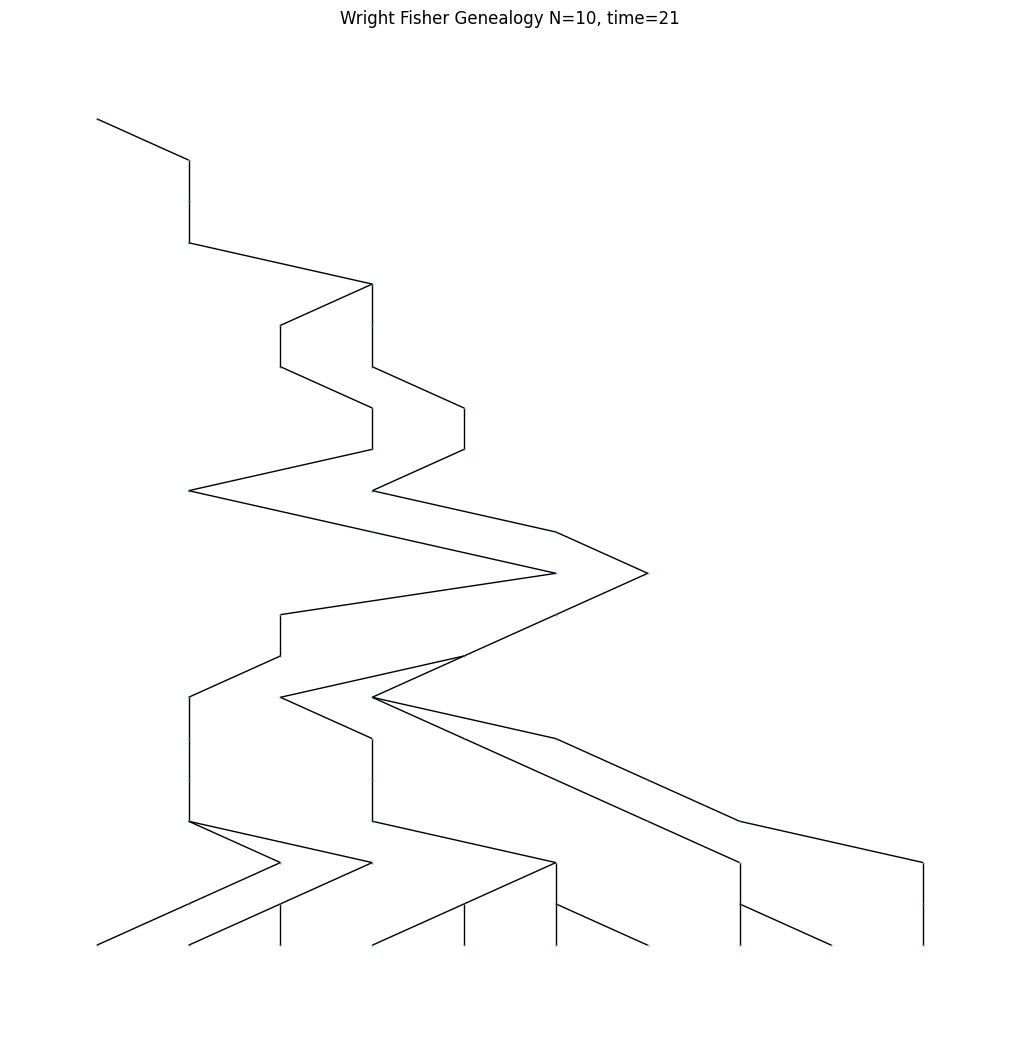

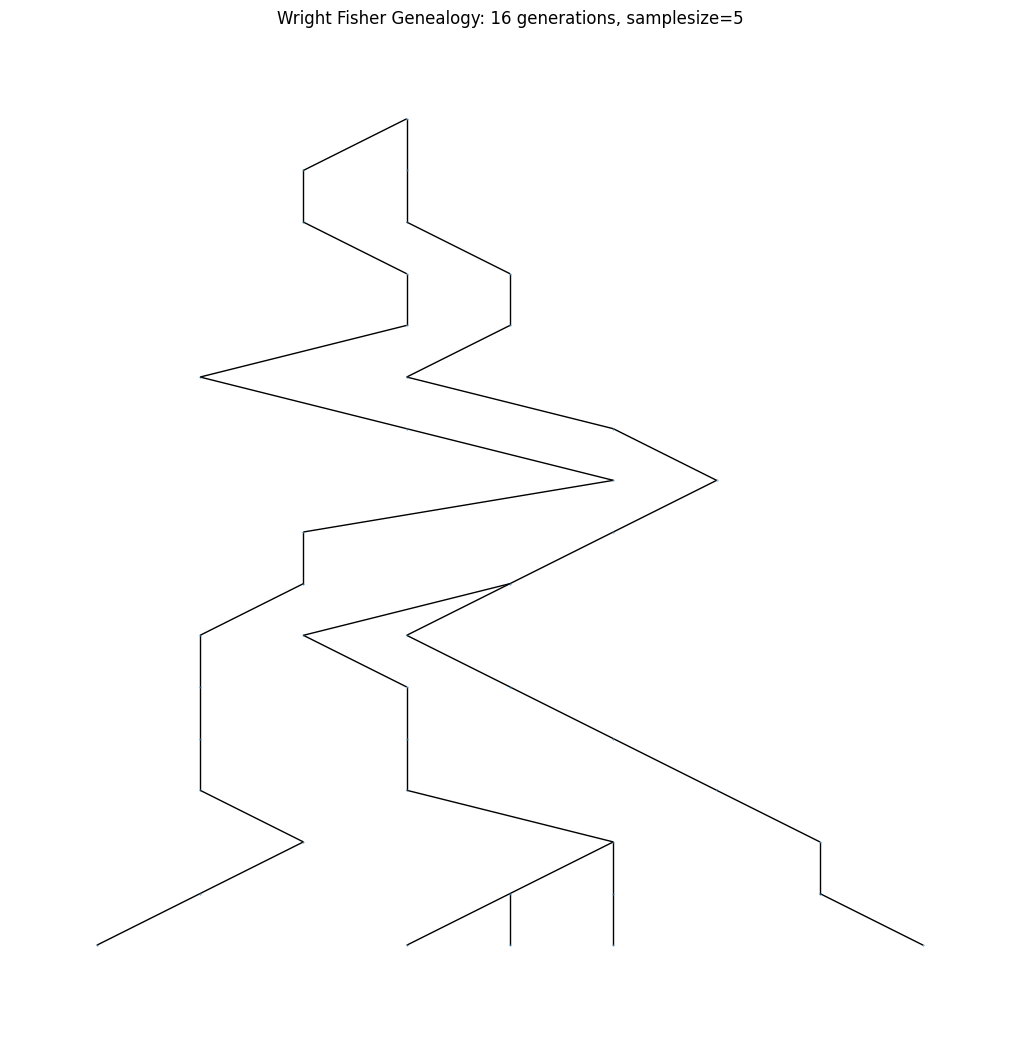

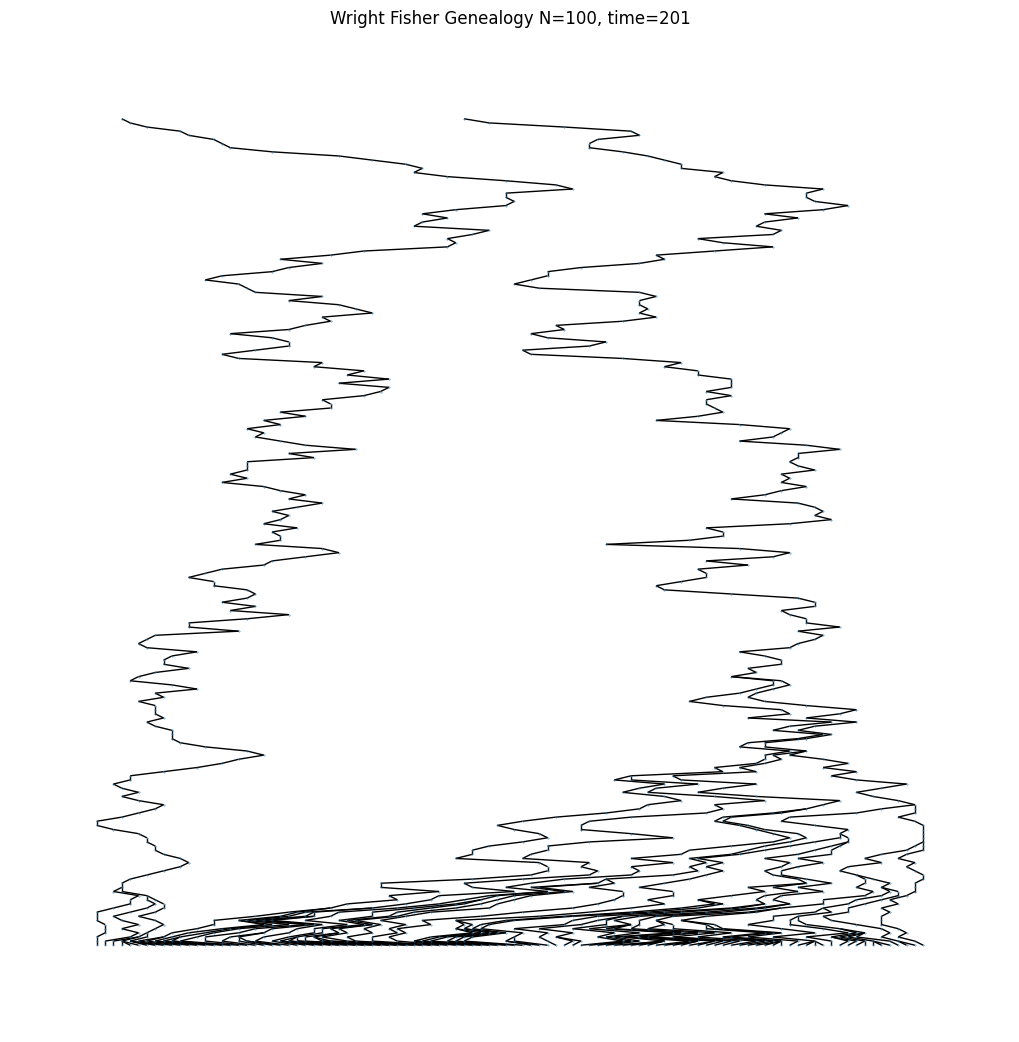

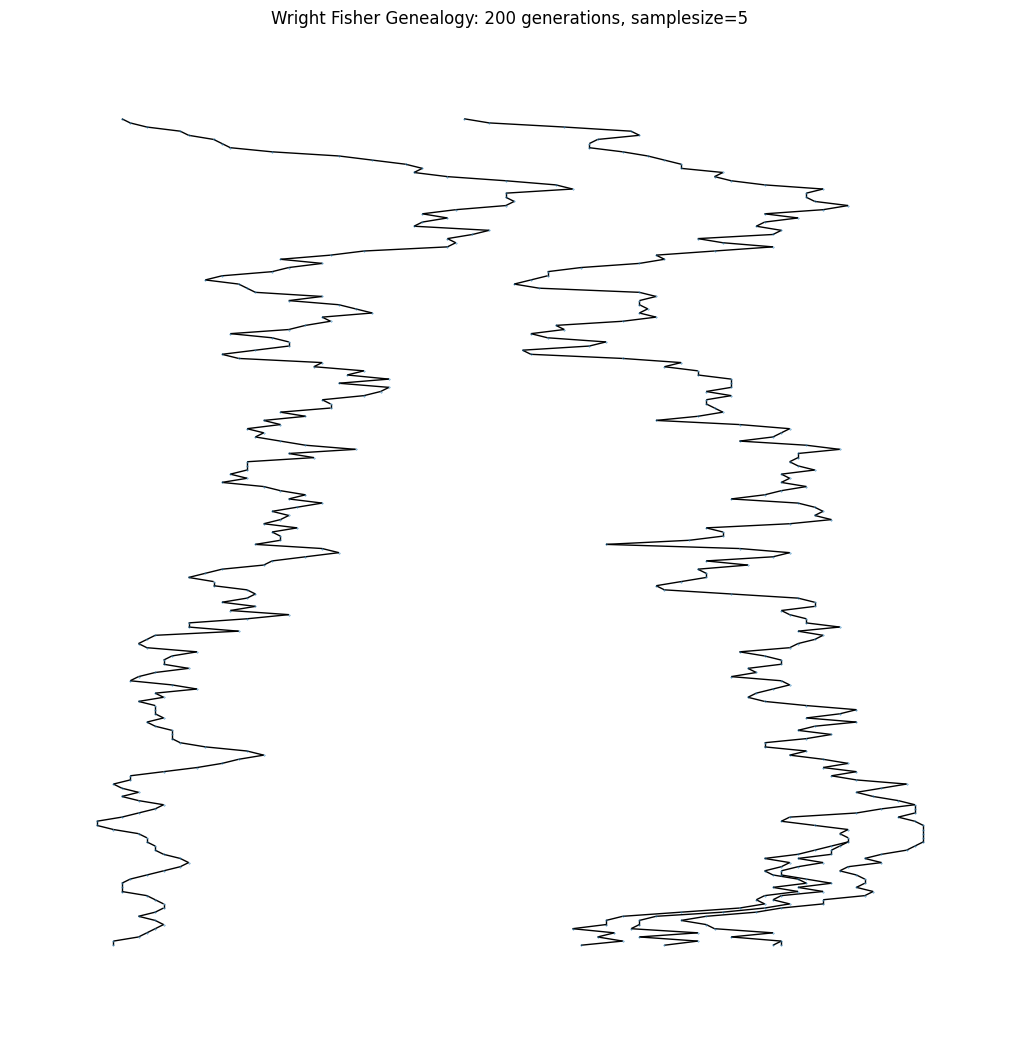

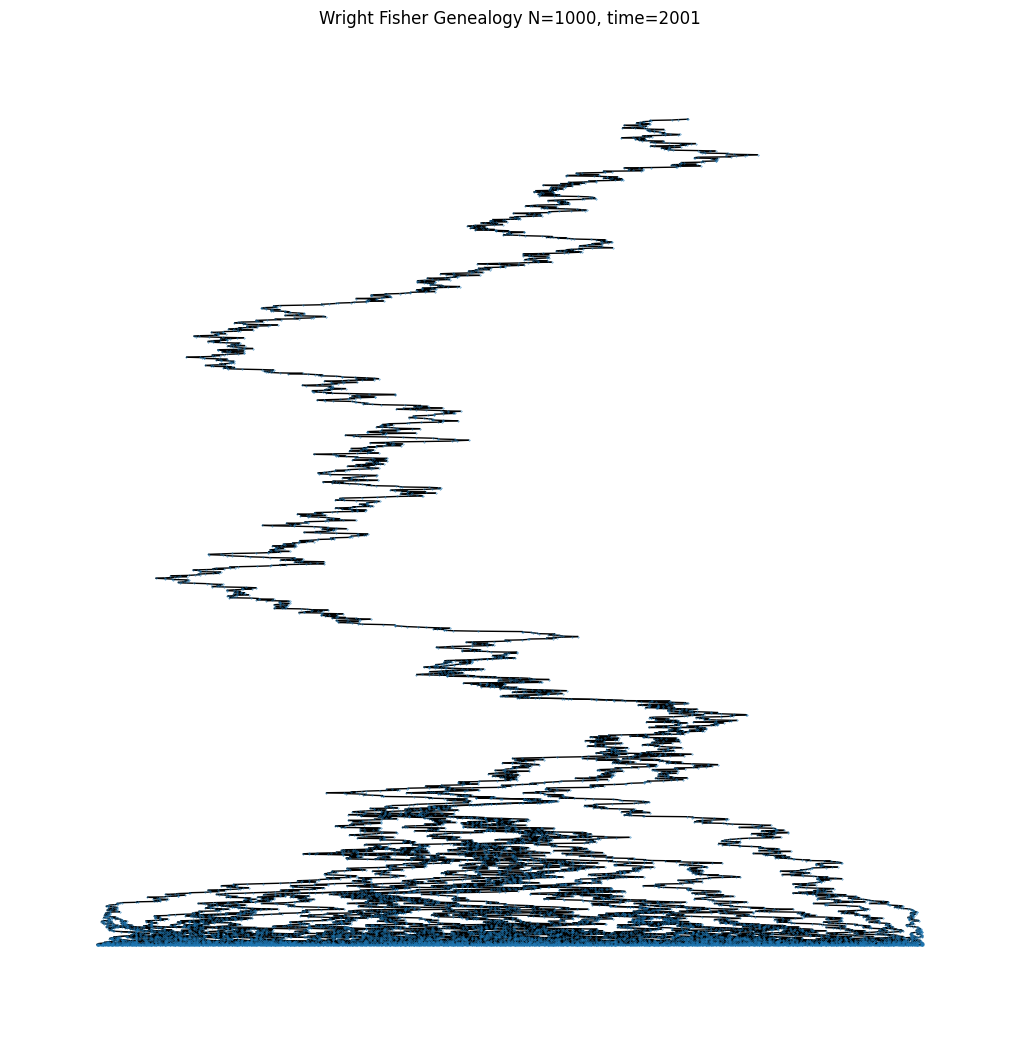

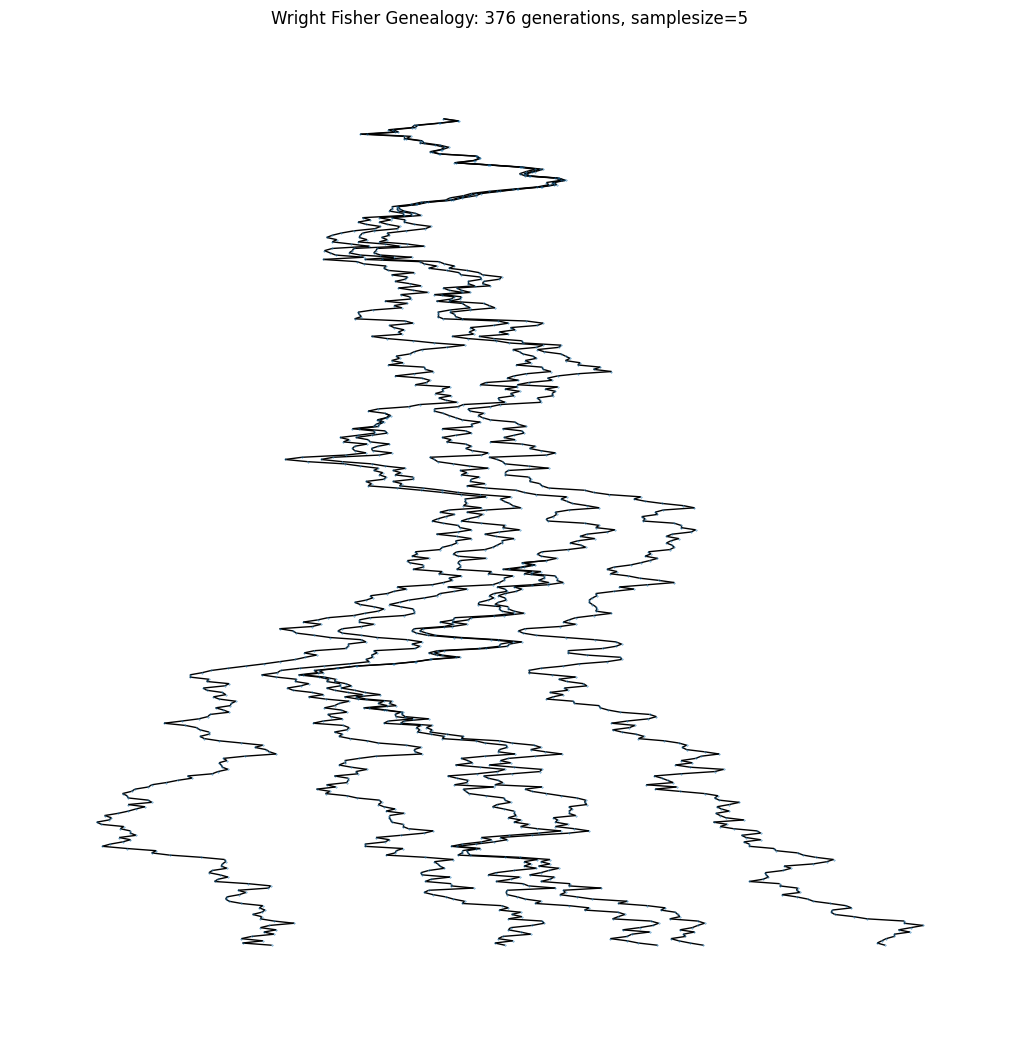

In [ ]:
for index in range(len(sm)):
  draw_graph(graph_back_gen_wf(sm[index]),xaxis=10,yaxis=10,title=f"Wright Fisher Genealogy N={len(sm[index])}, time={len(sm[index][0])}")
  draw_graph(graph_sample_back_gen_wf(mrca_sm[index],sm[index]),xaxis=10,yaxis=10,title=f"Wright Fisher Genealogy: {mrca_sm[index][0]} generations, samplesize={5}")

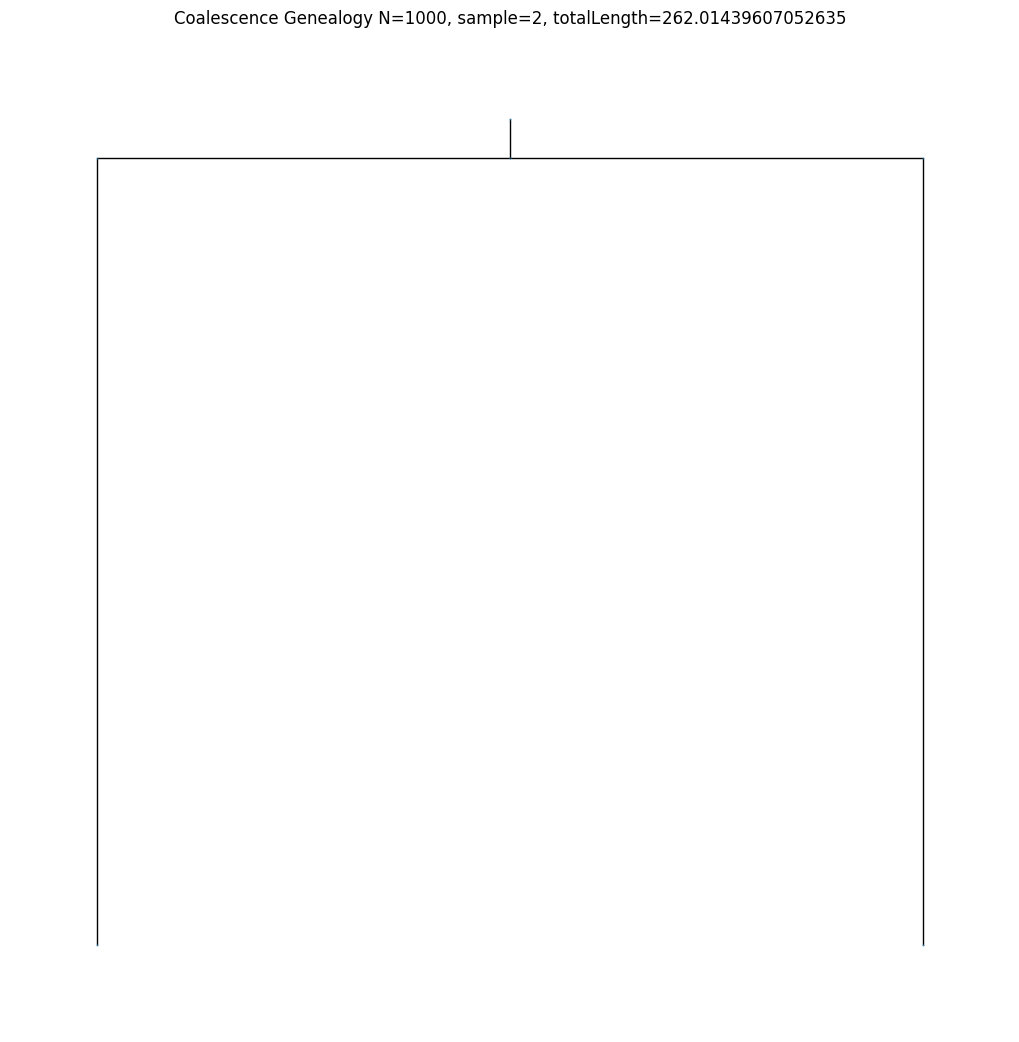

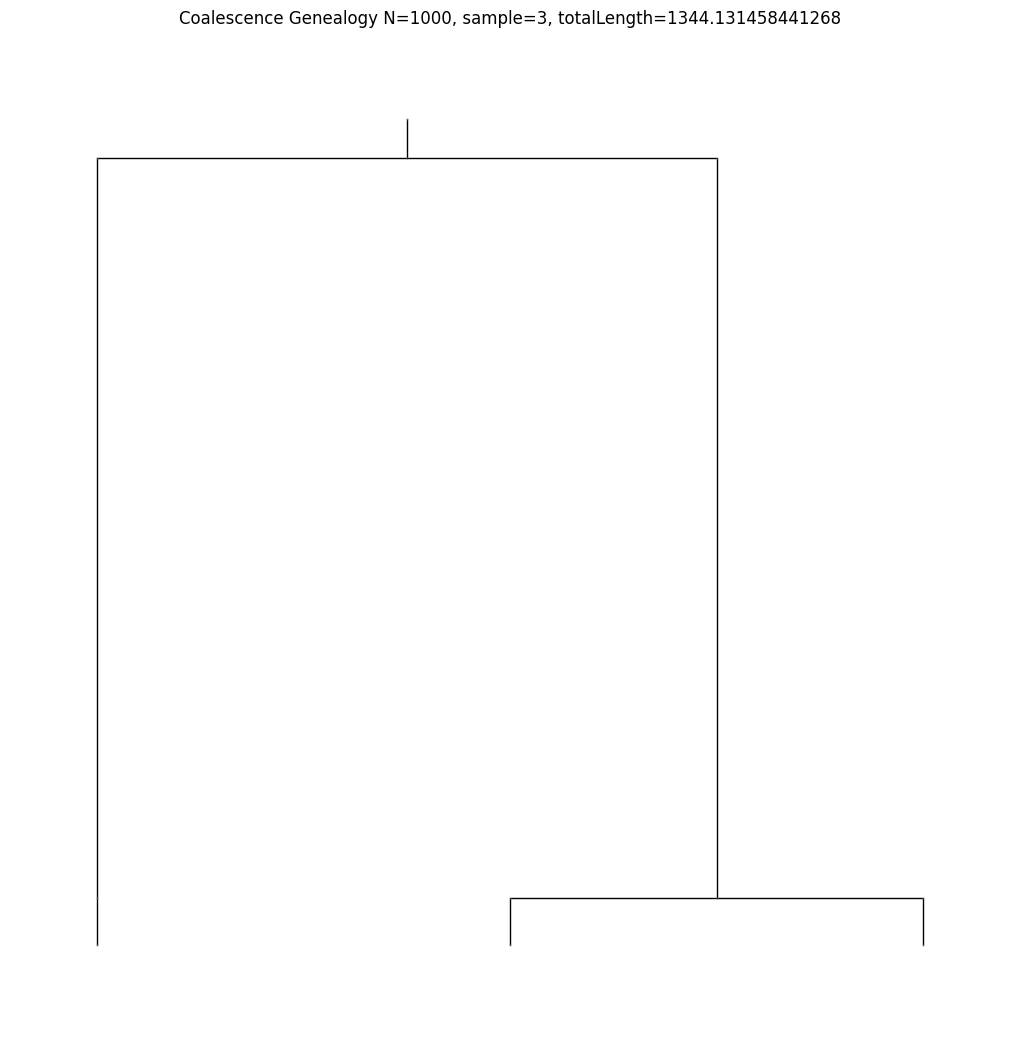

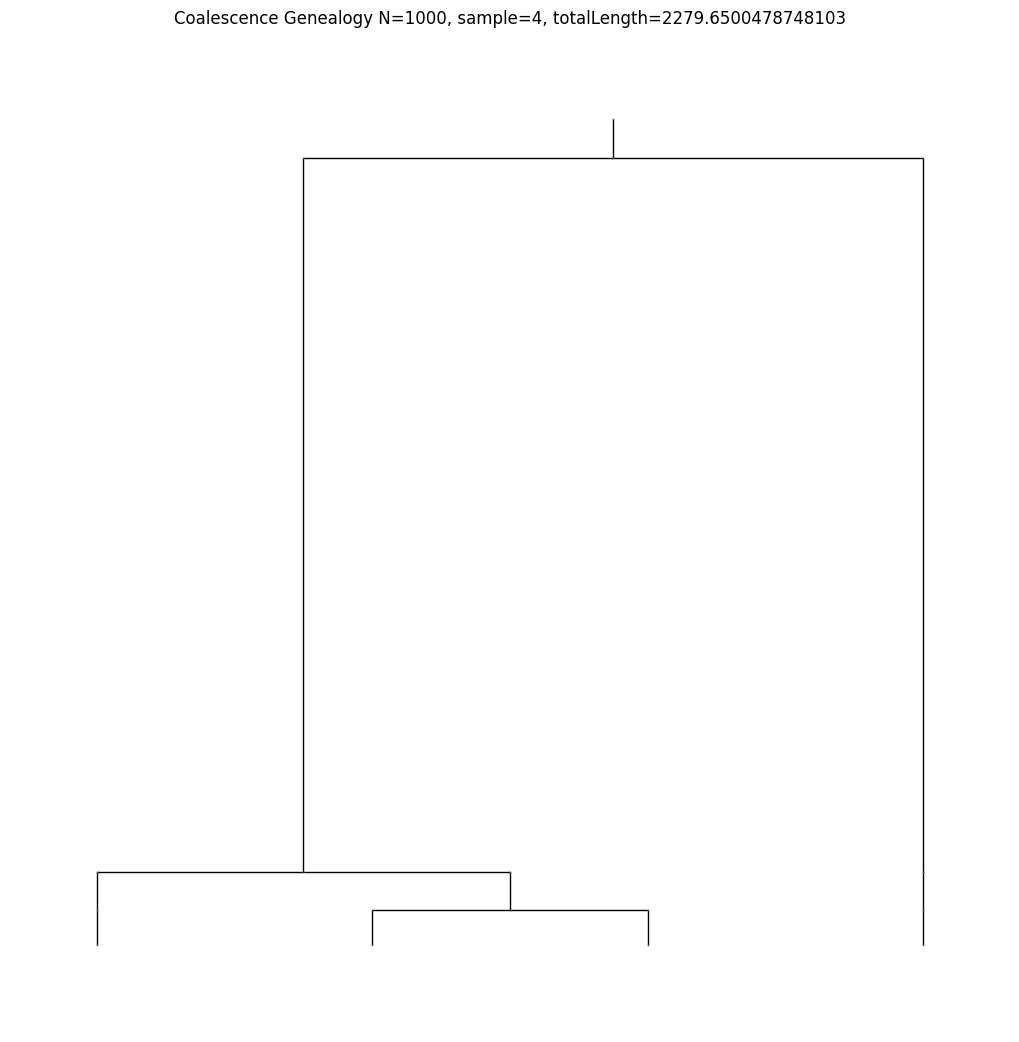

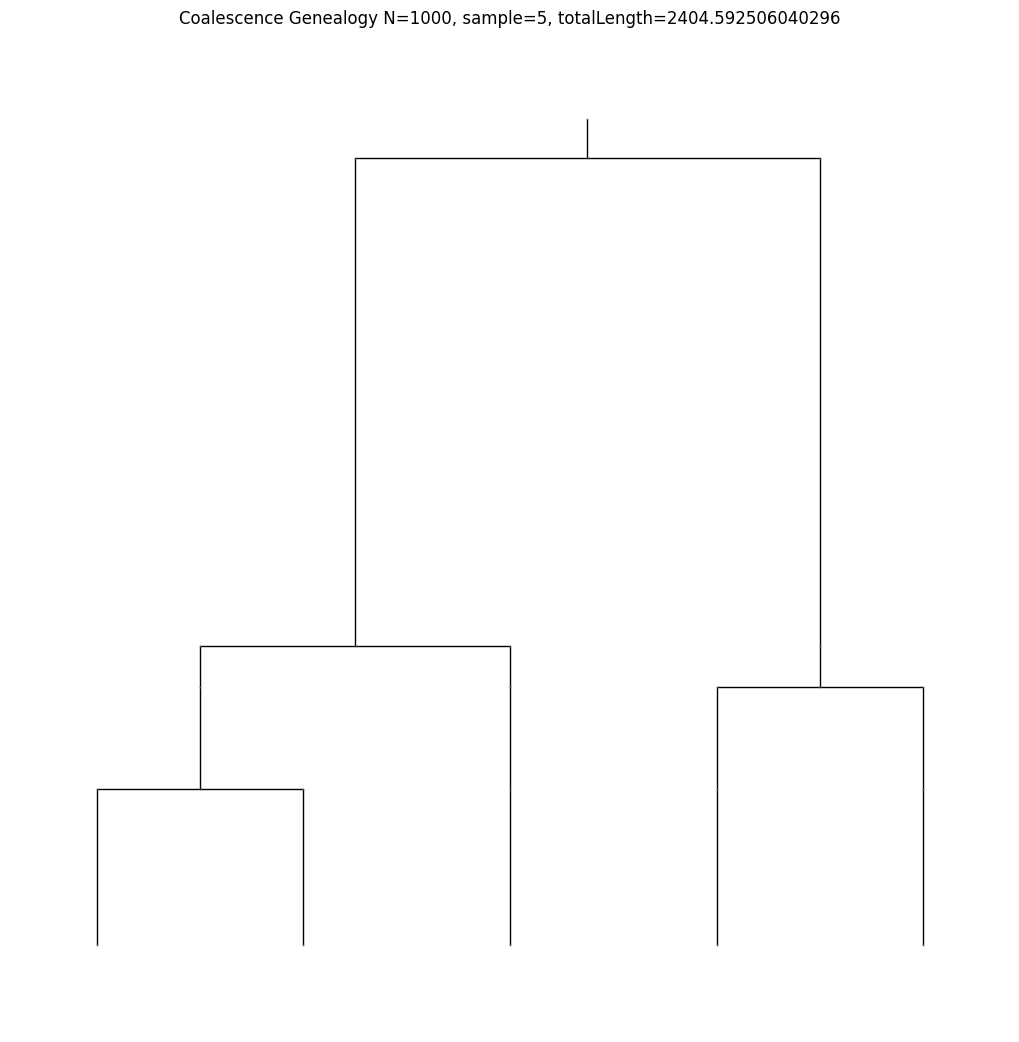

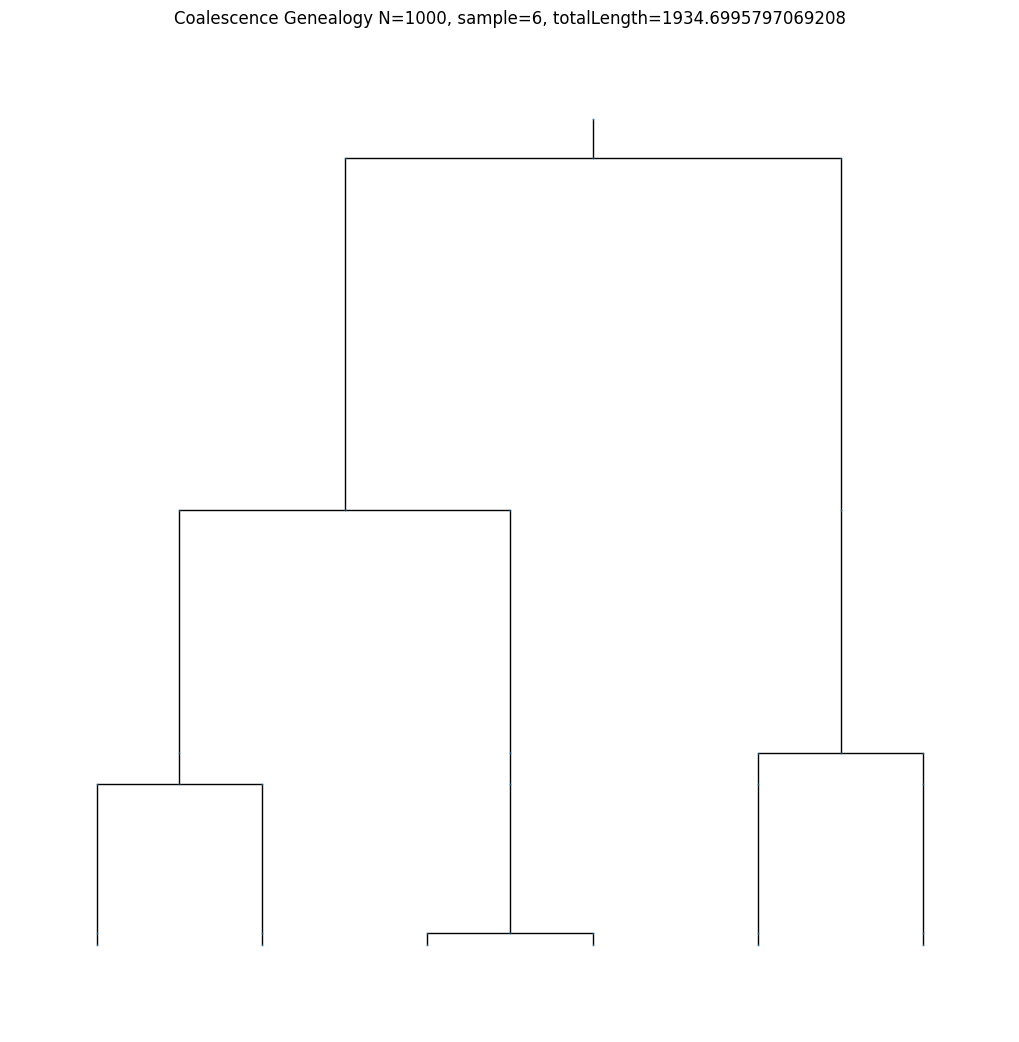

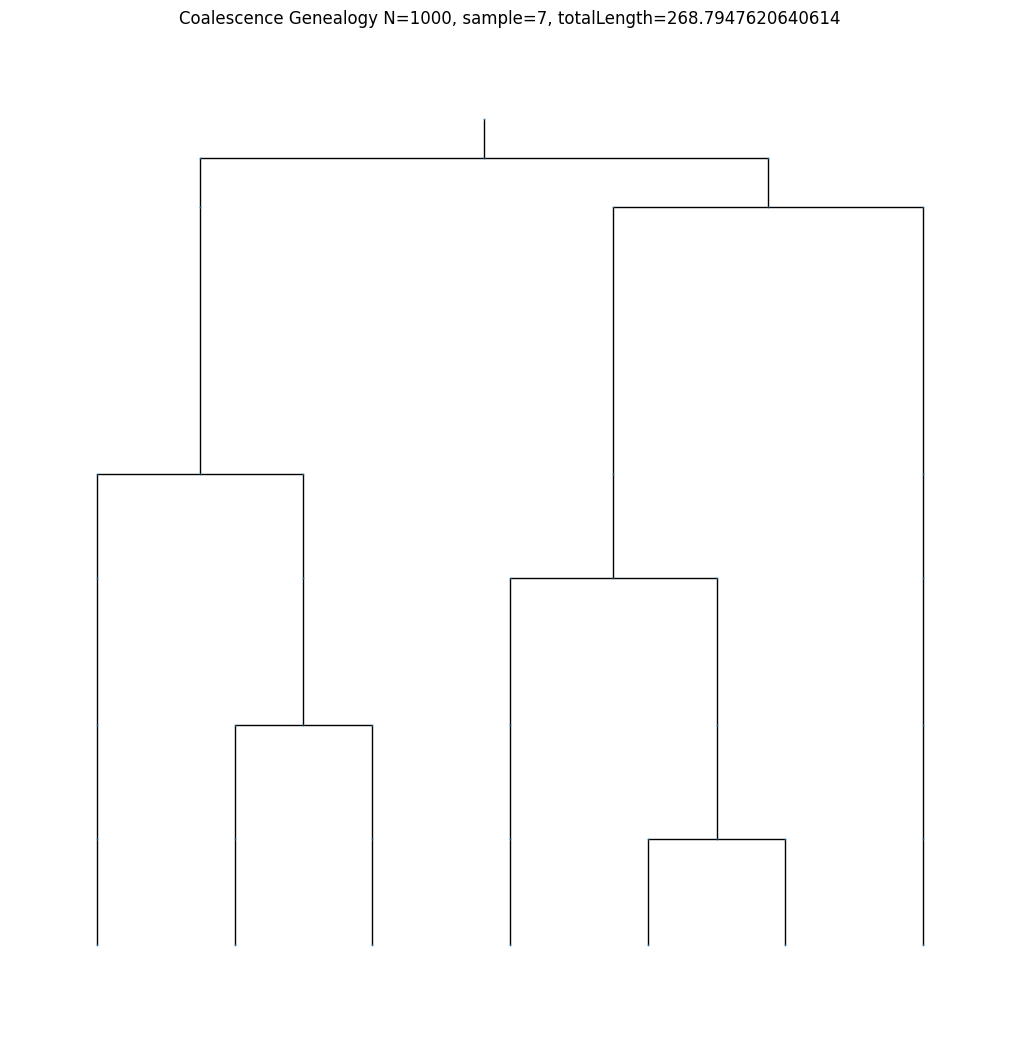

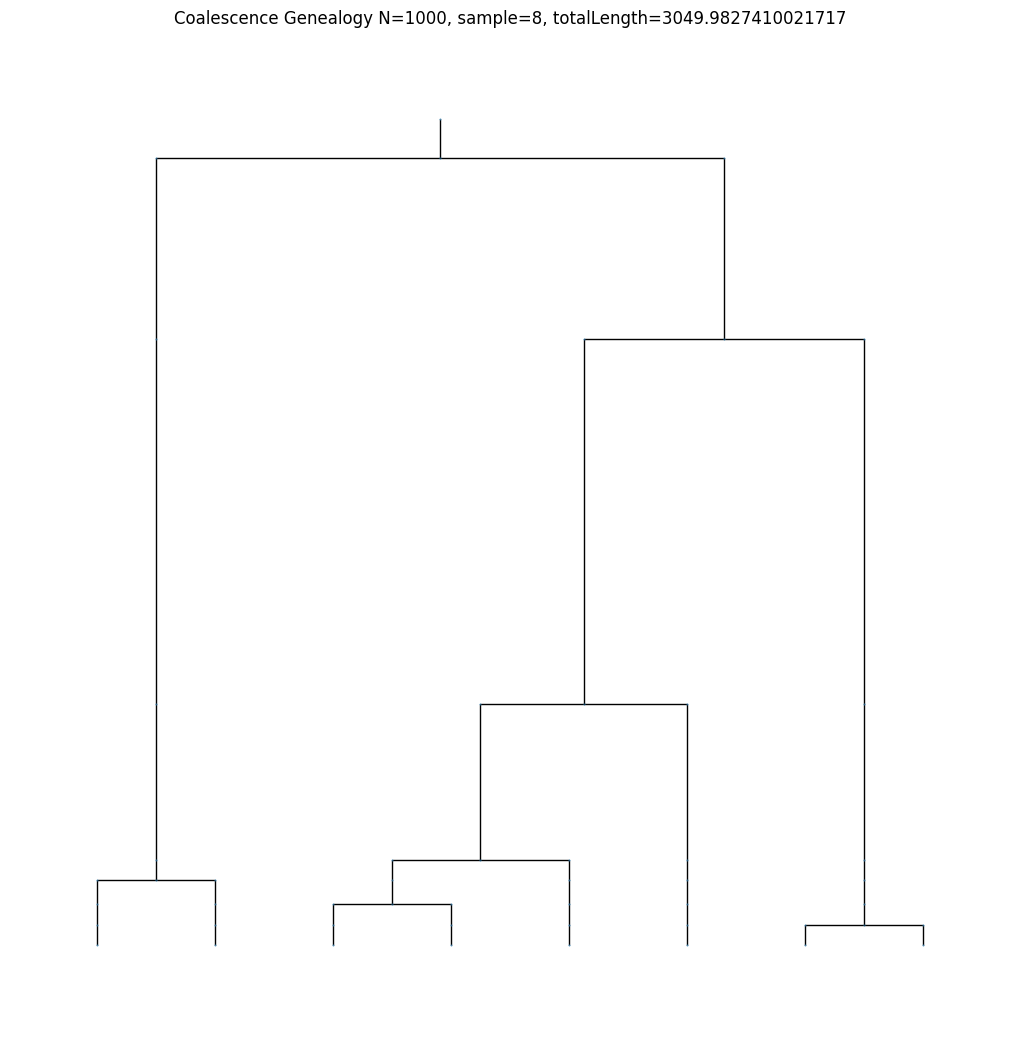

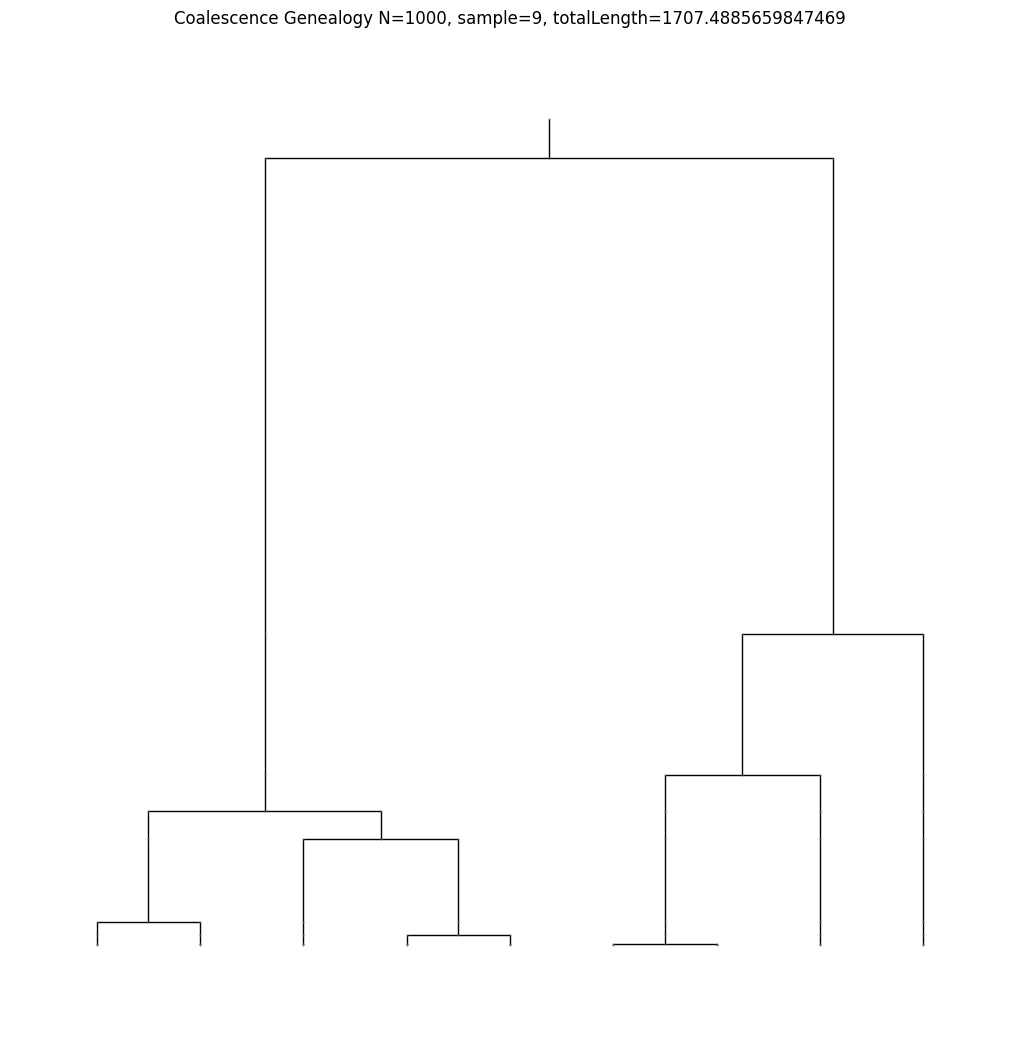

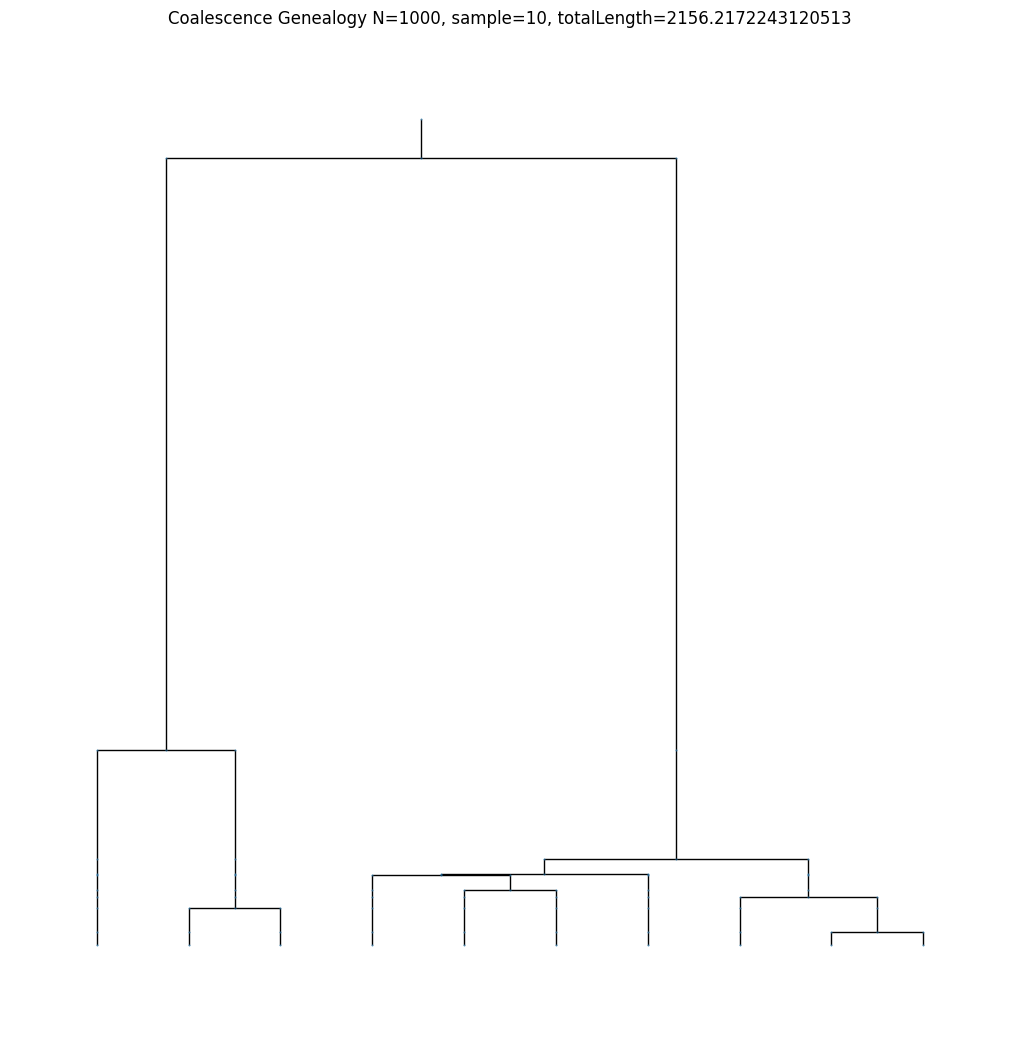

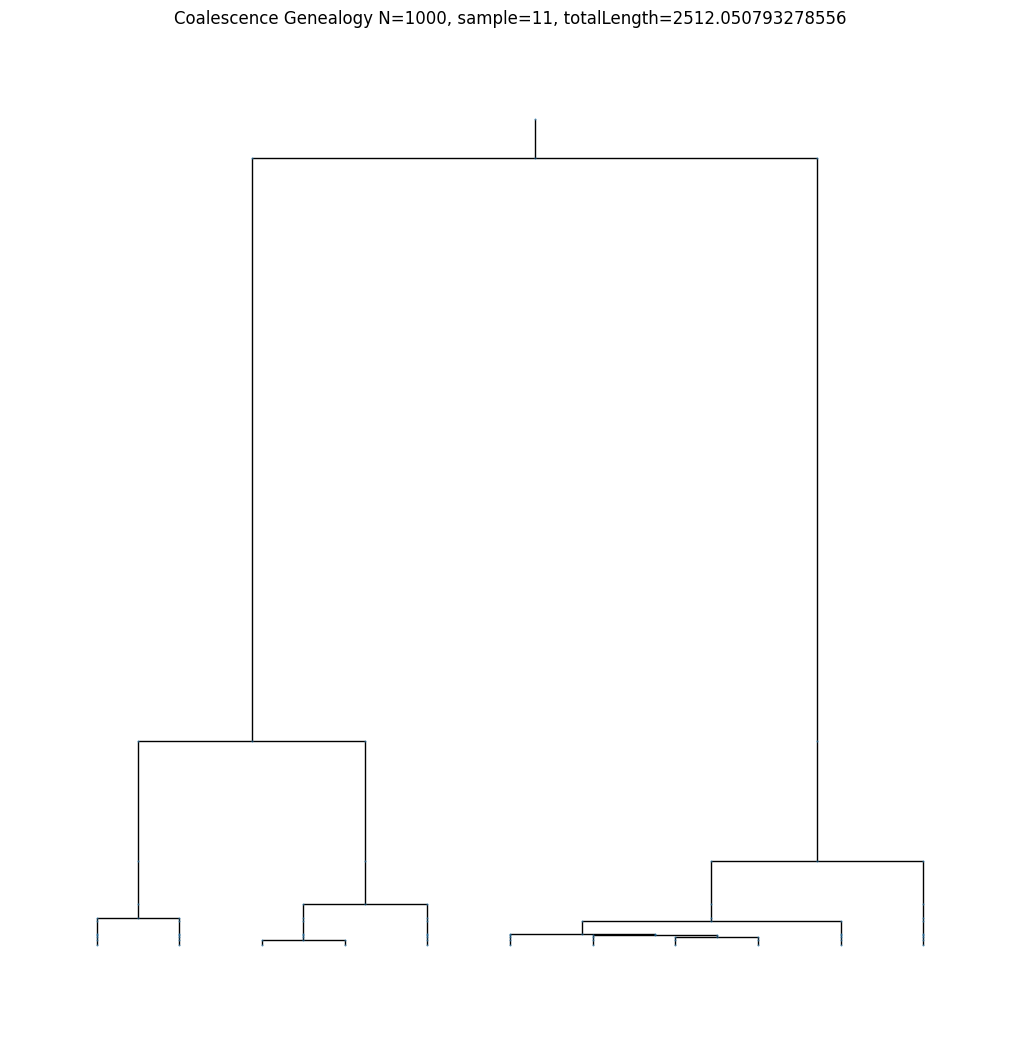

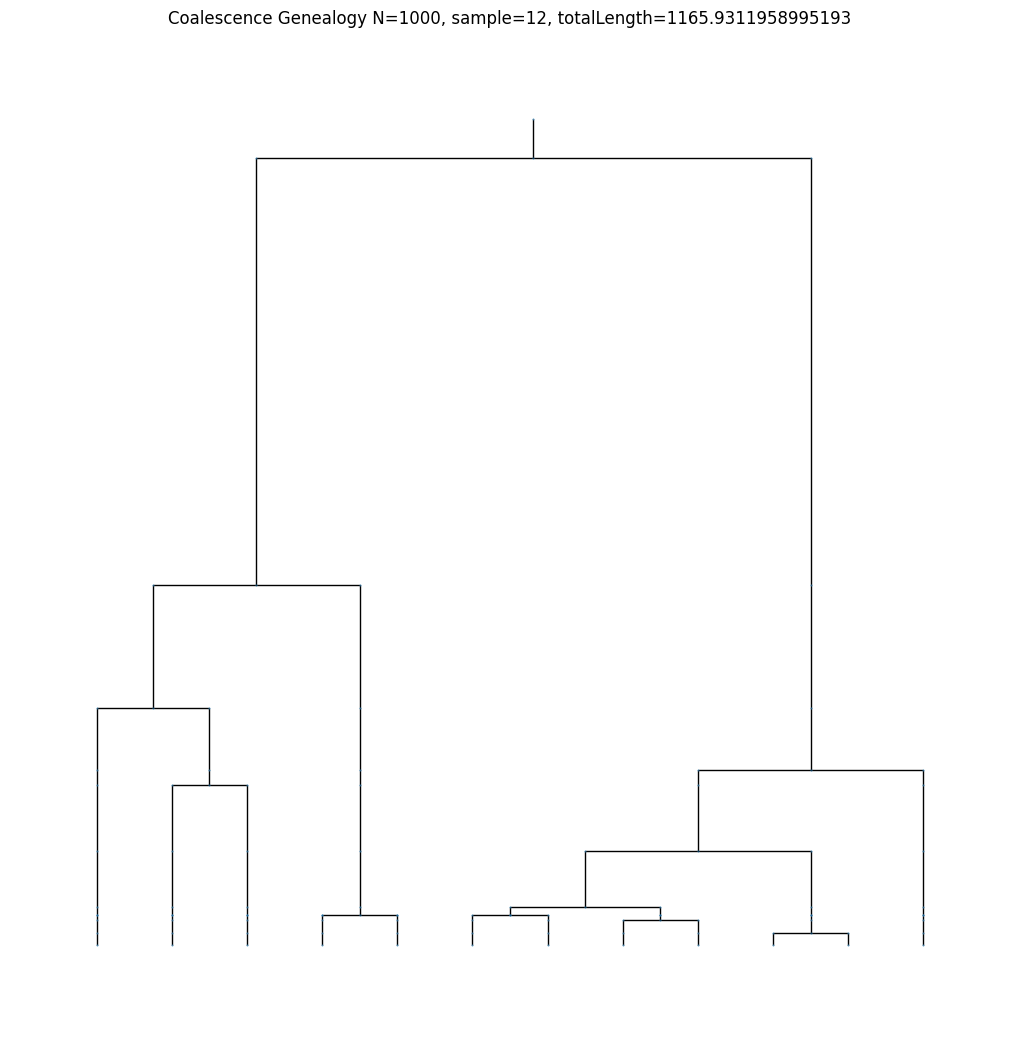

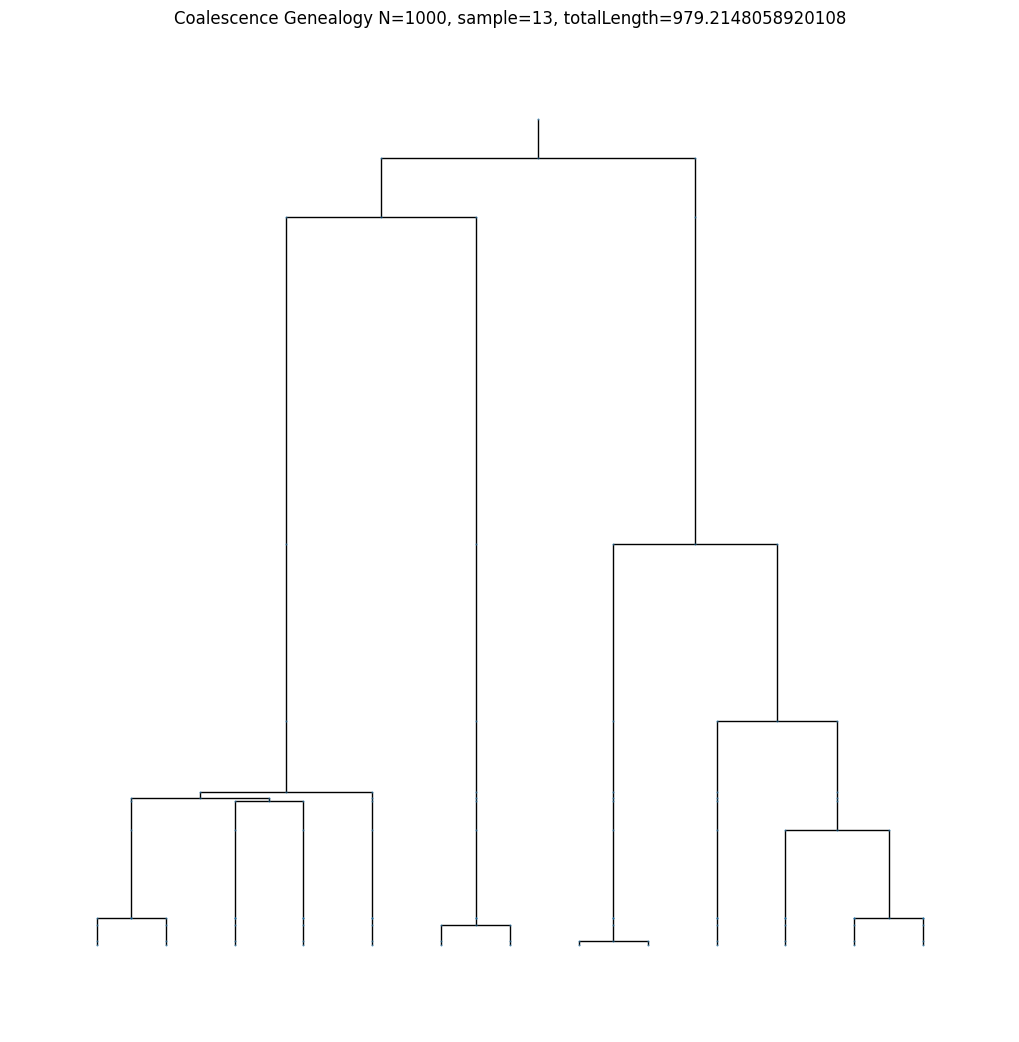

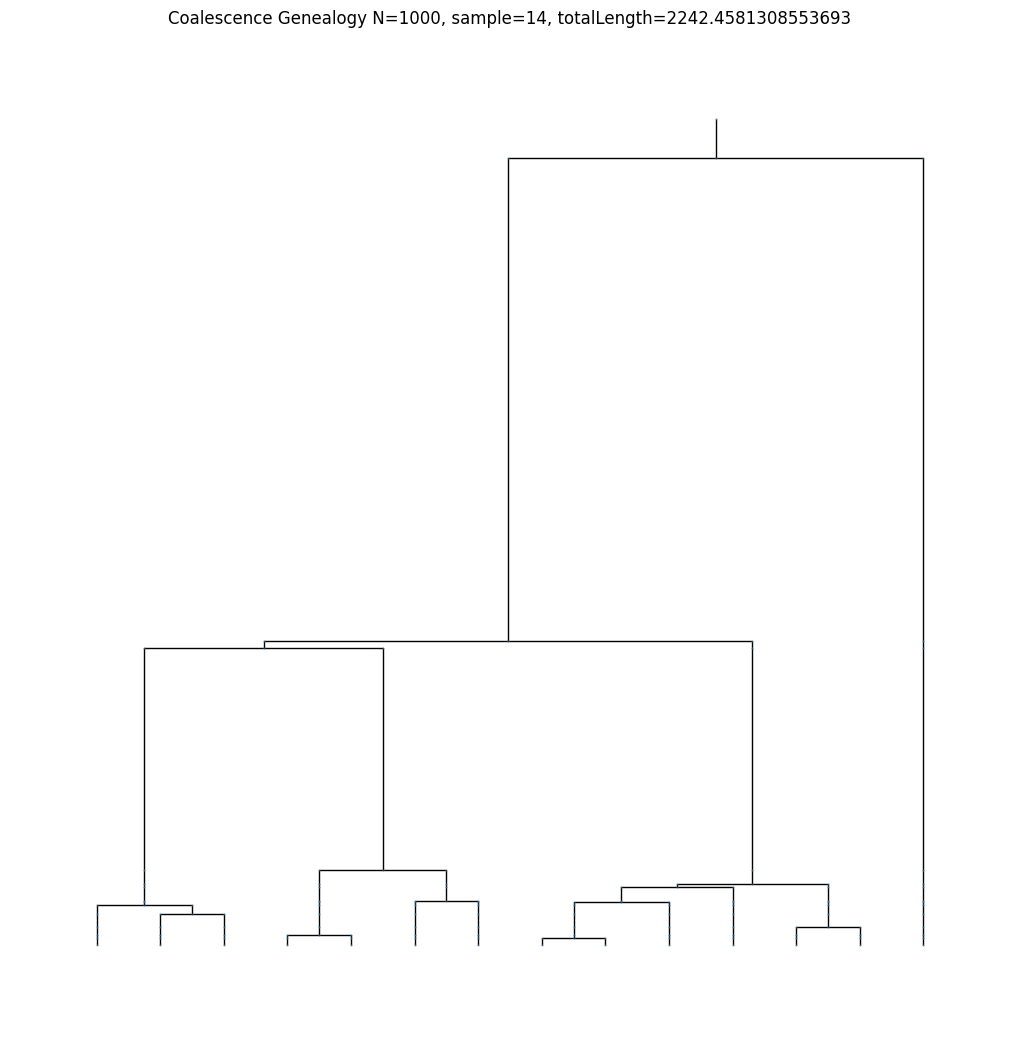

In [ ]:
for j in range(2,15):
  exp=expo_samples(j,1000)
  draw_graph(graph_coalescence_new_version(exp), xaxis=7, yaxis=7, title=f"Coalescence Genealogy N={1000}, sample={j}, totalLength={sum(exp)}")

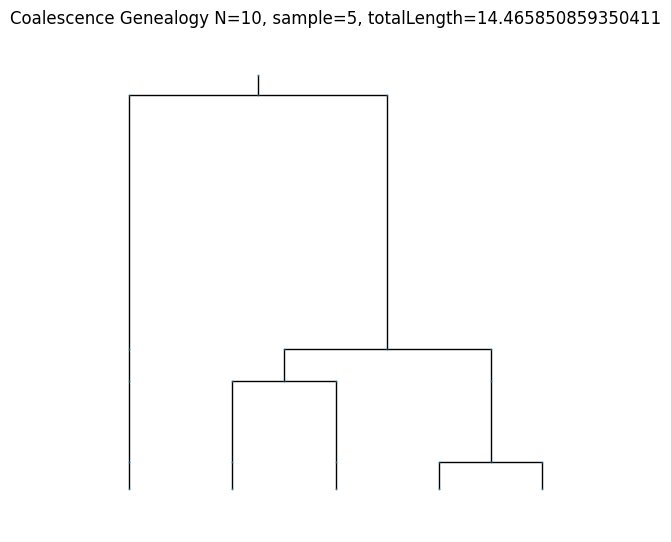

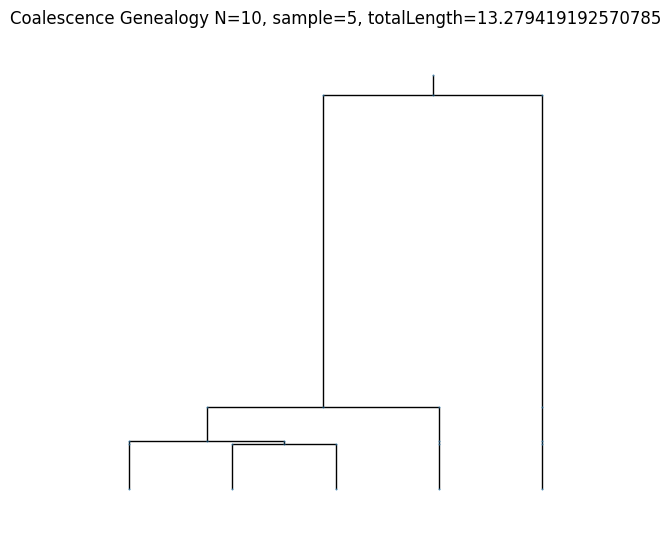

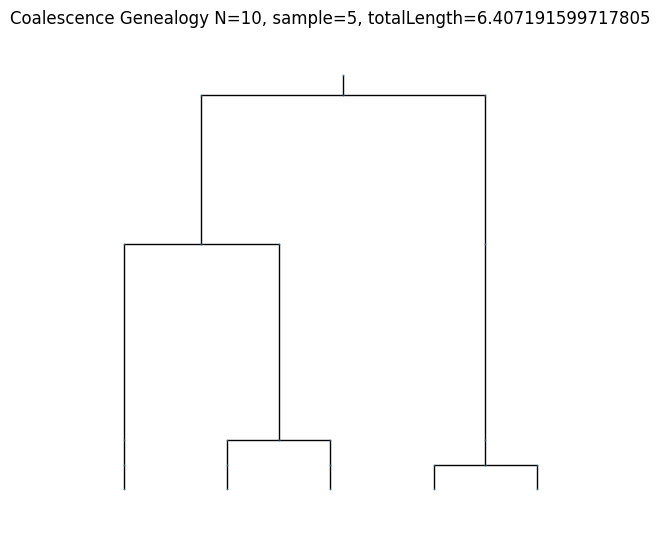

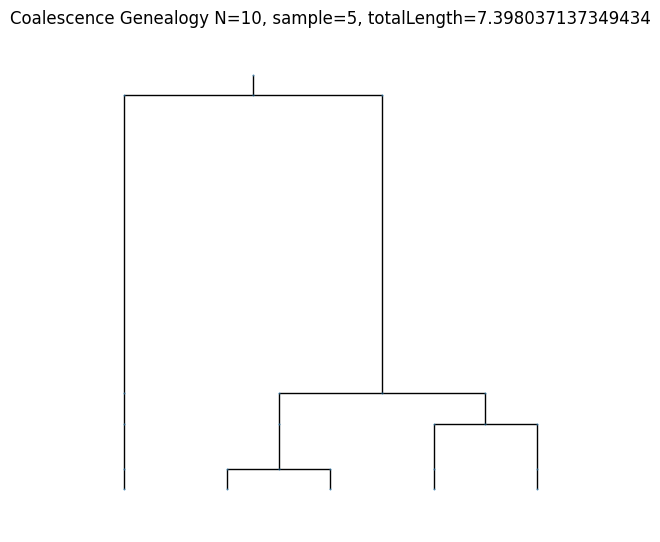

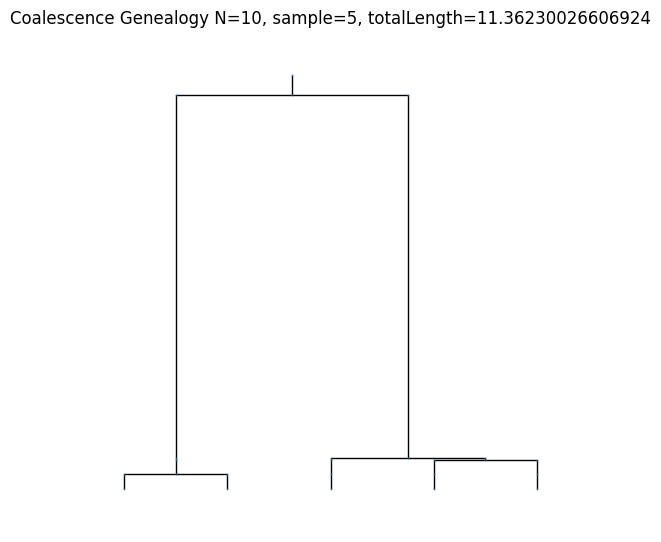

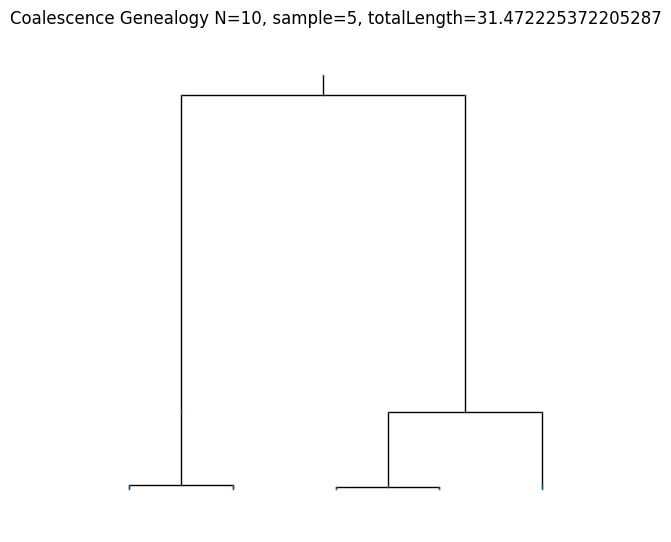

In [8]:
for j in range(2,8):
  exp=expo_samples(5,10)
  draw_graph(graph_coalescence_new_version(exp), xaxis=5, yaxis=5, title=f"Coalescence Genealogy N={10}, sample={5}, totalLength={sum(exp)}")

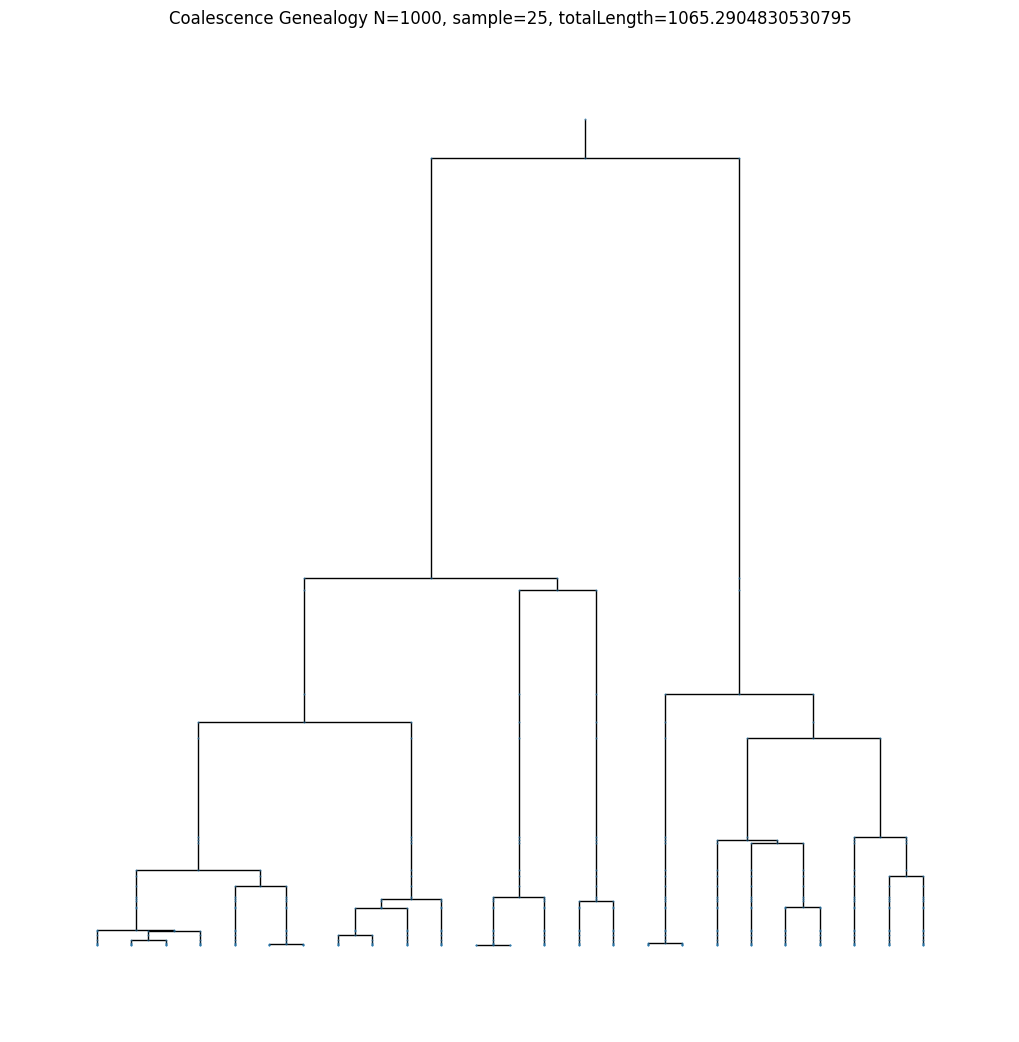

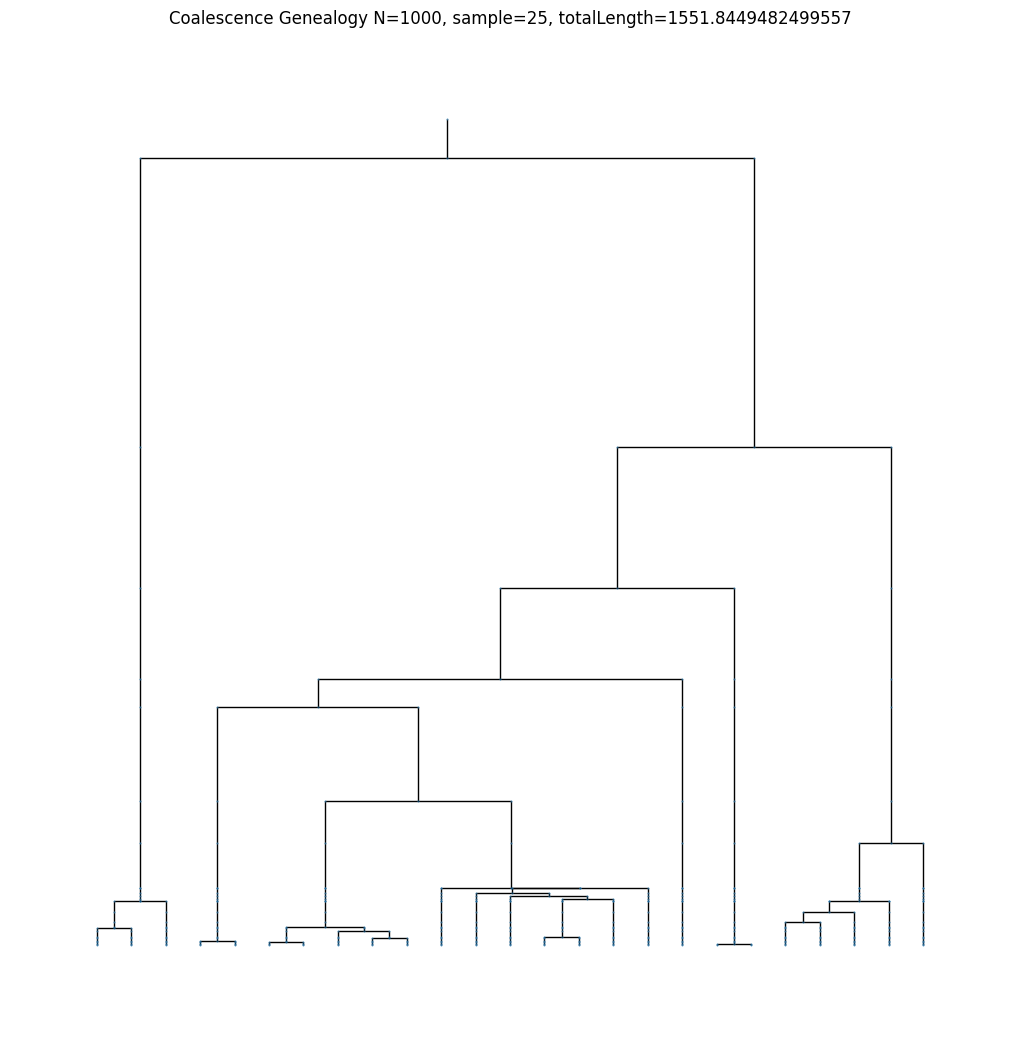

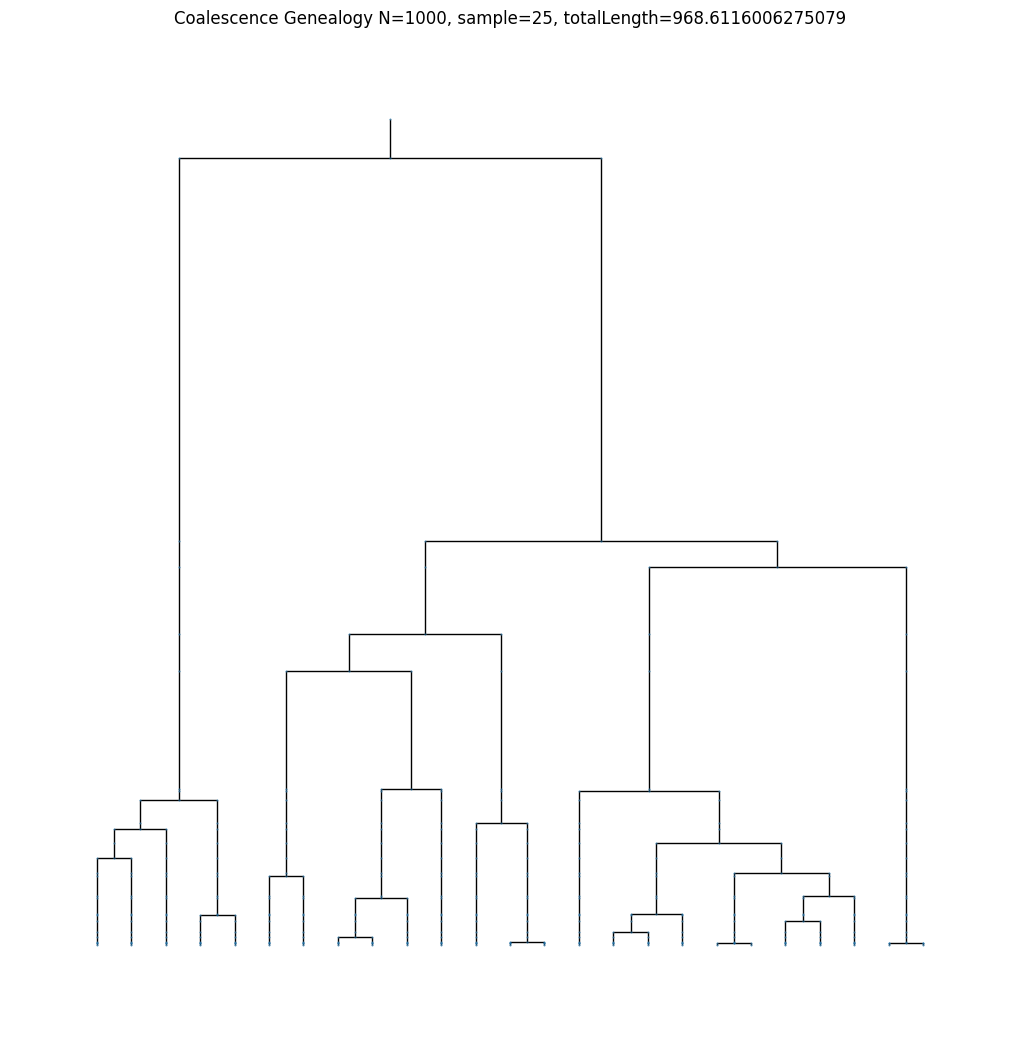

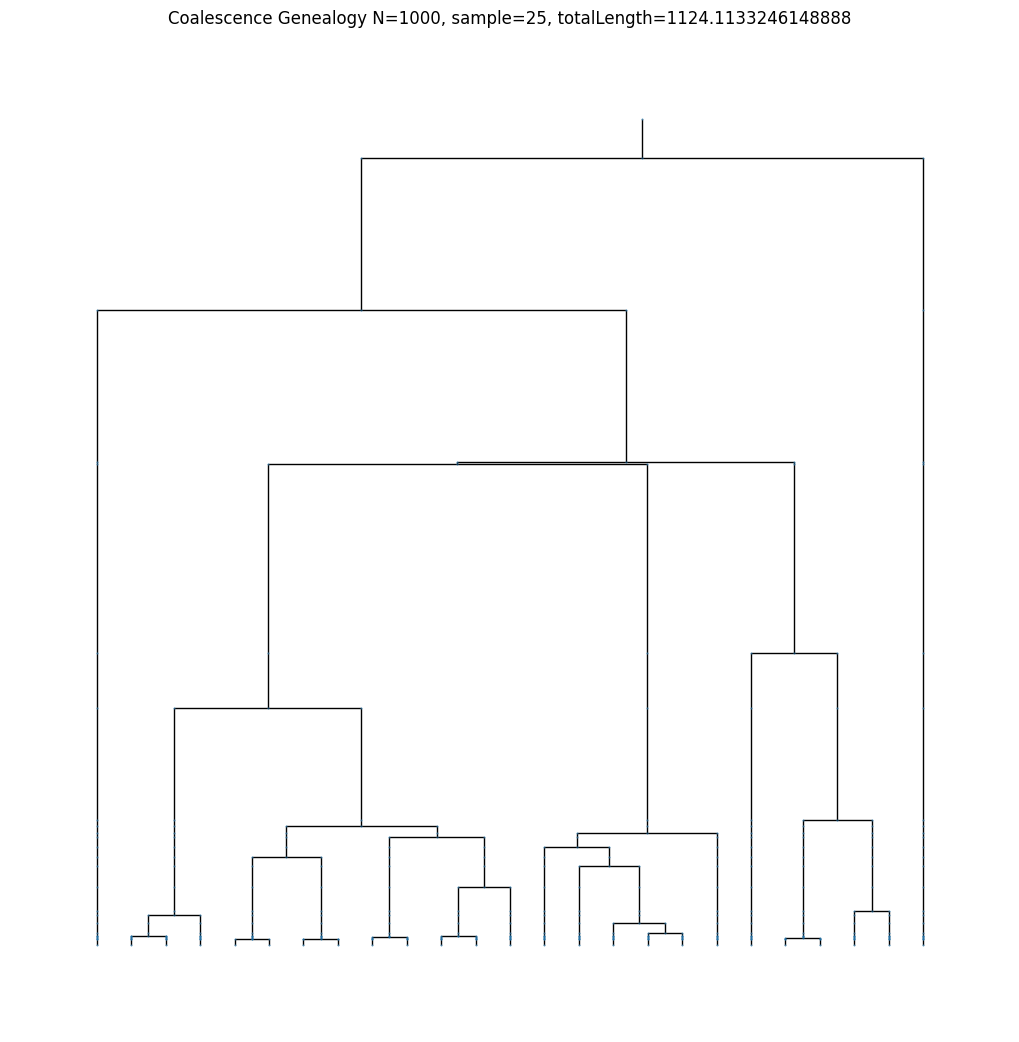

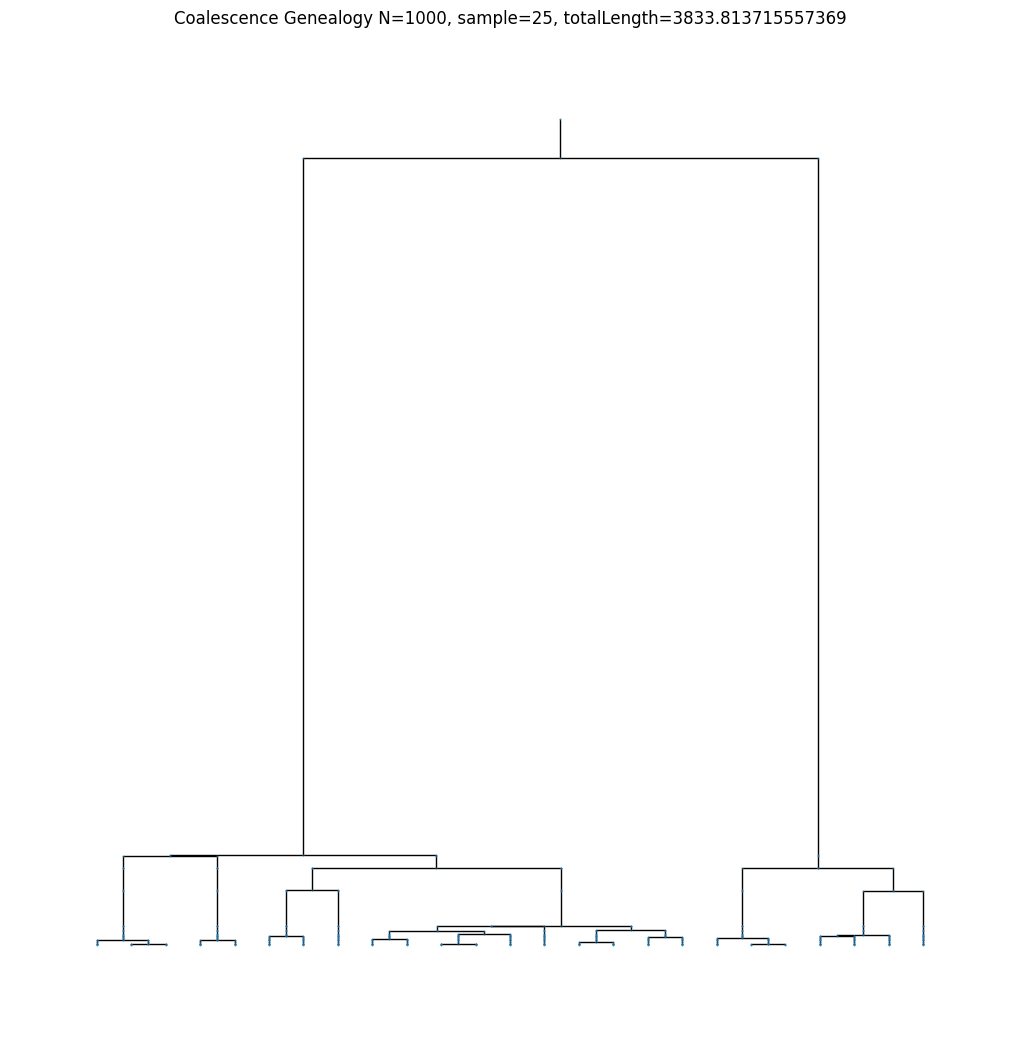

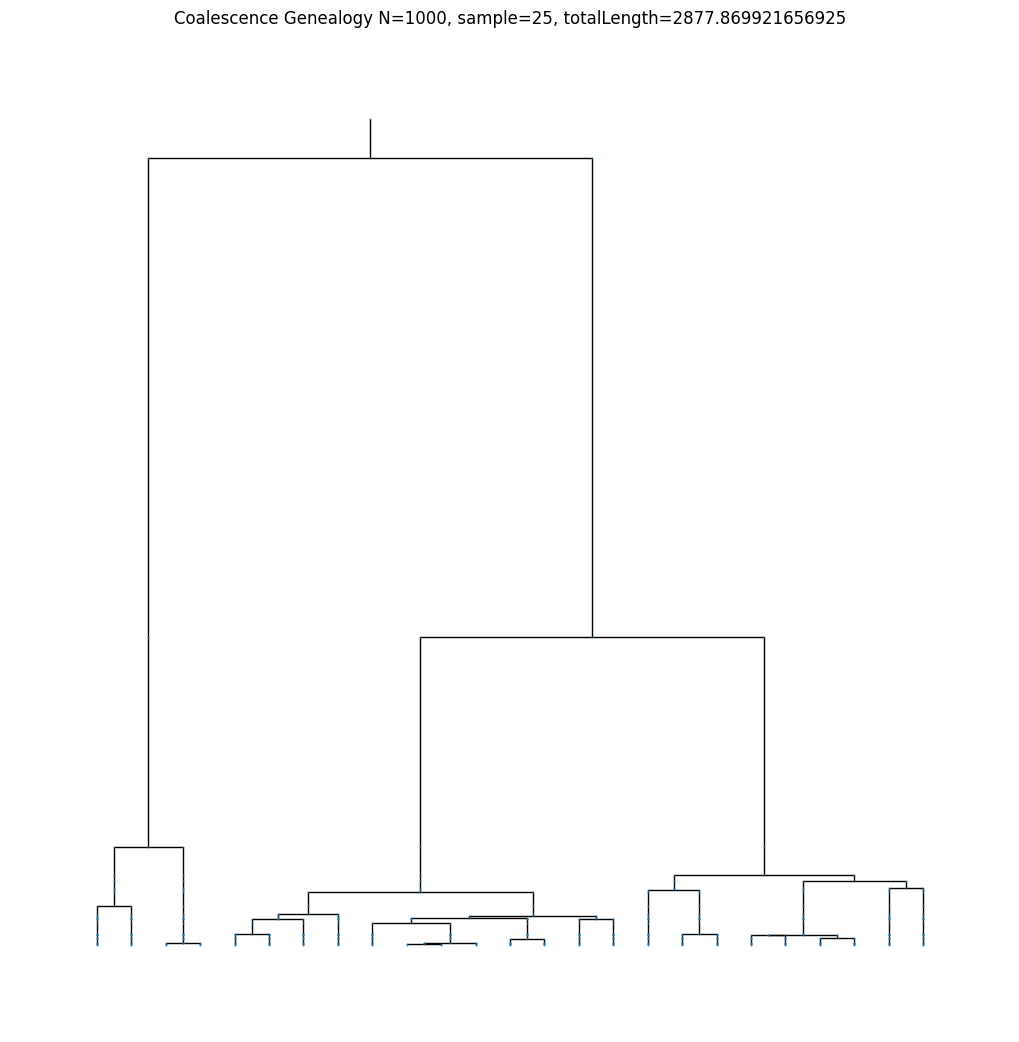

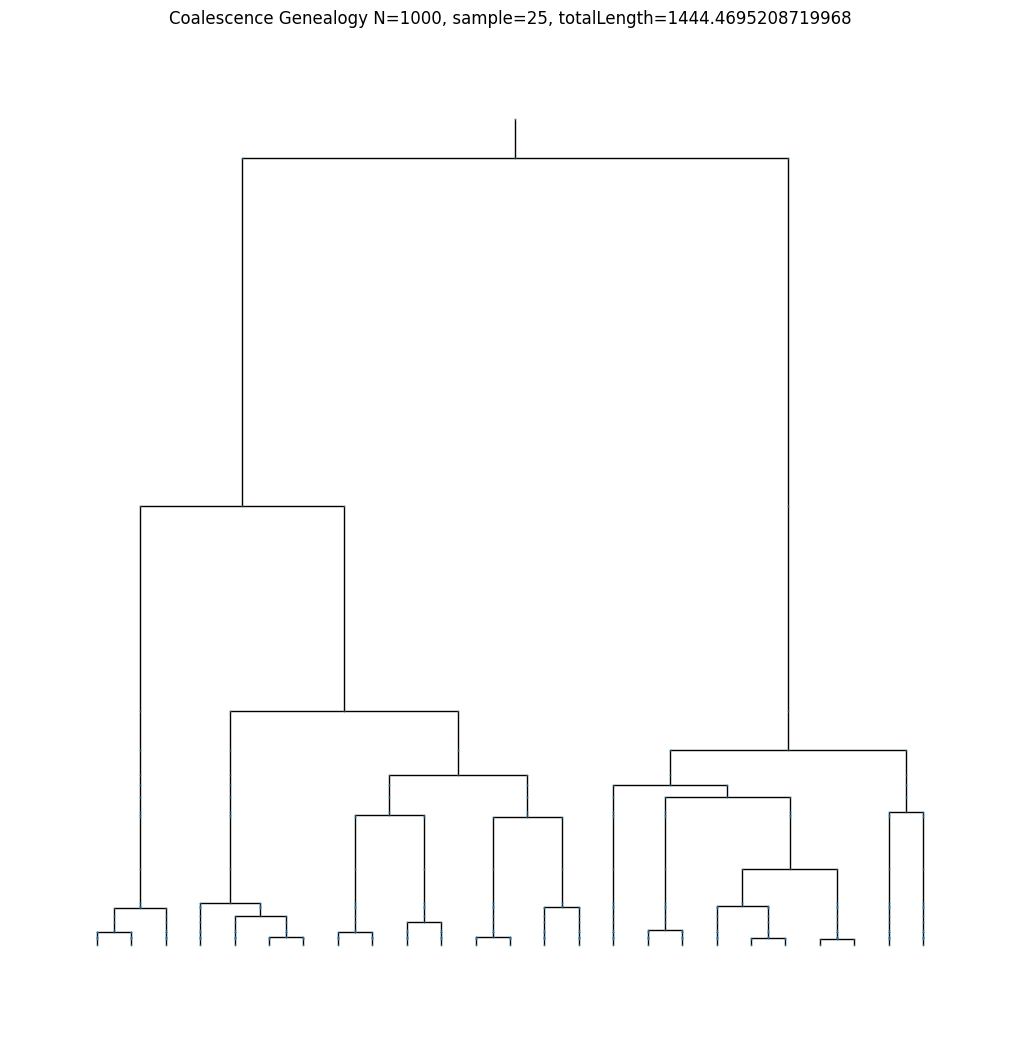

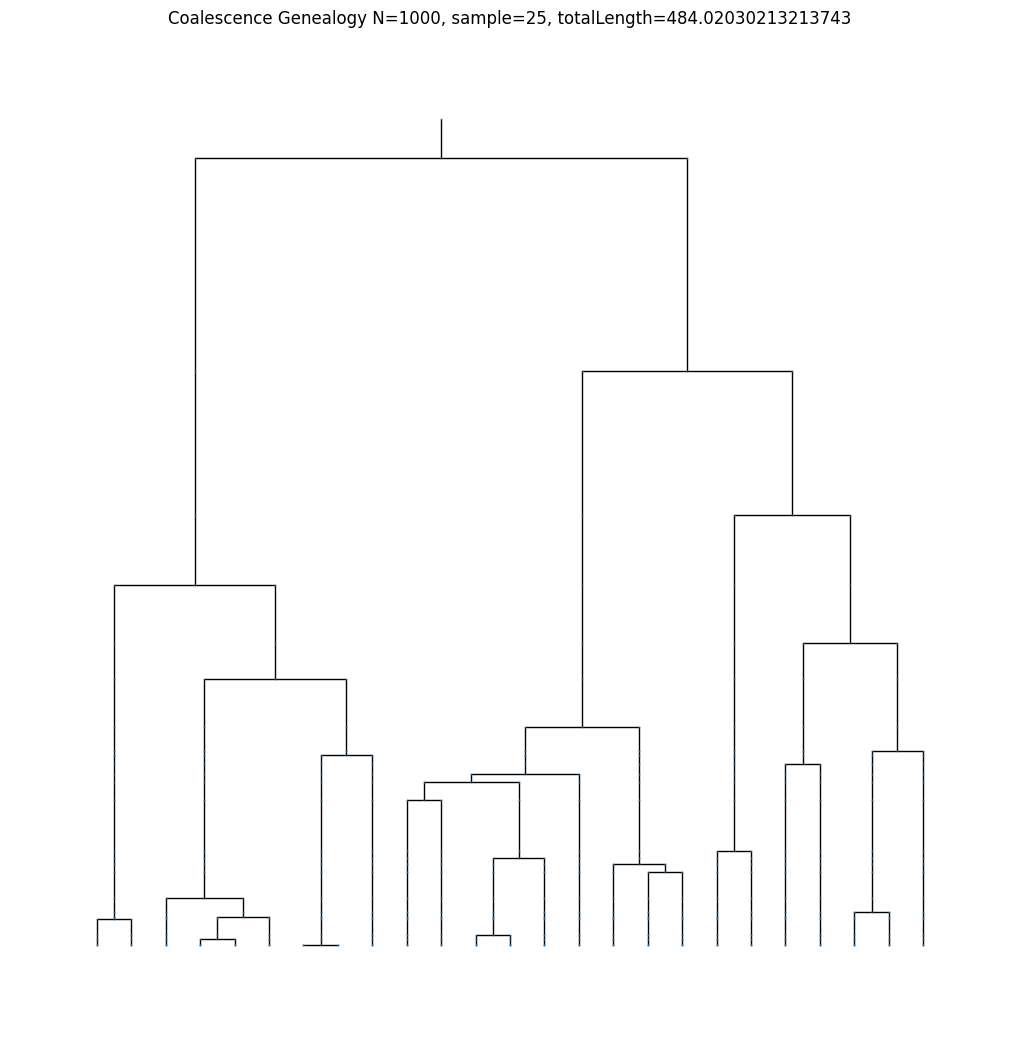

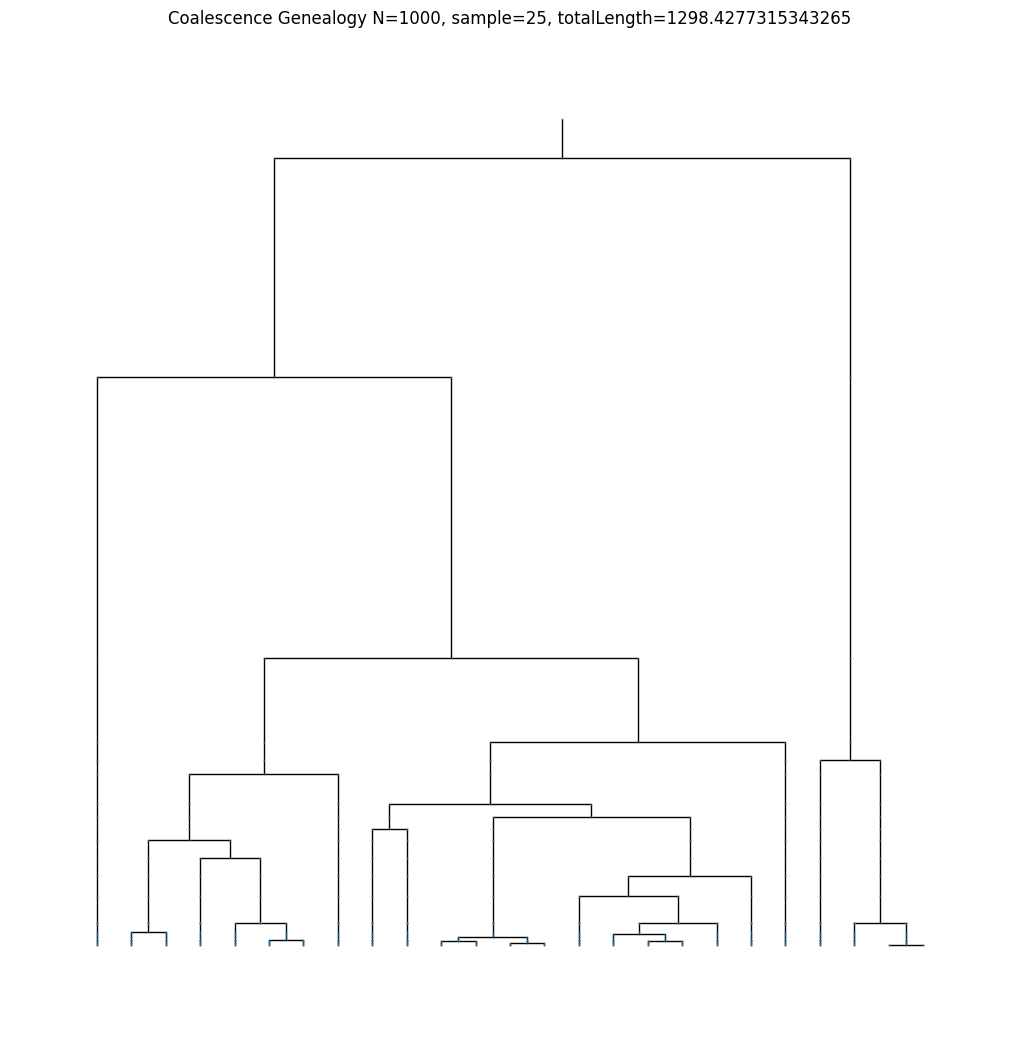

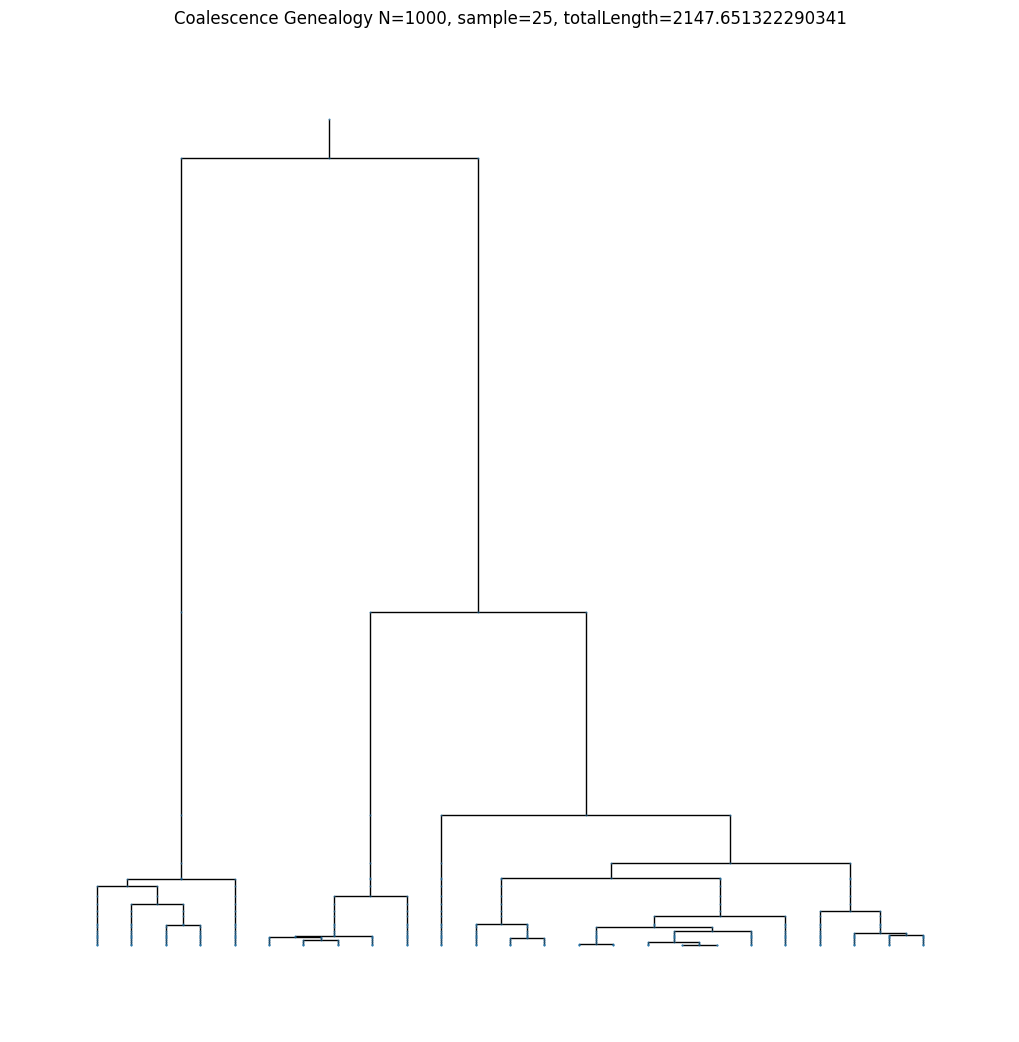

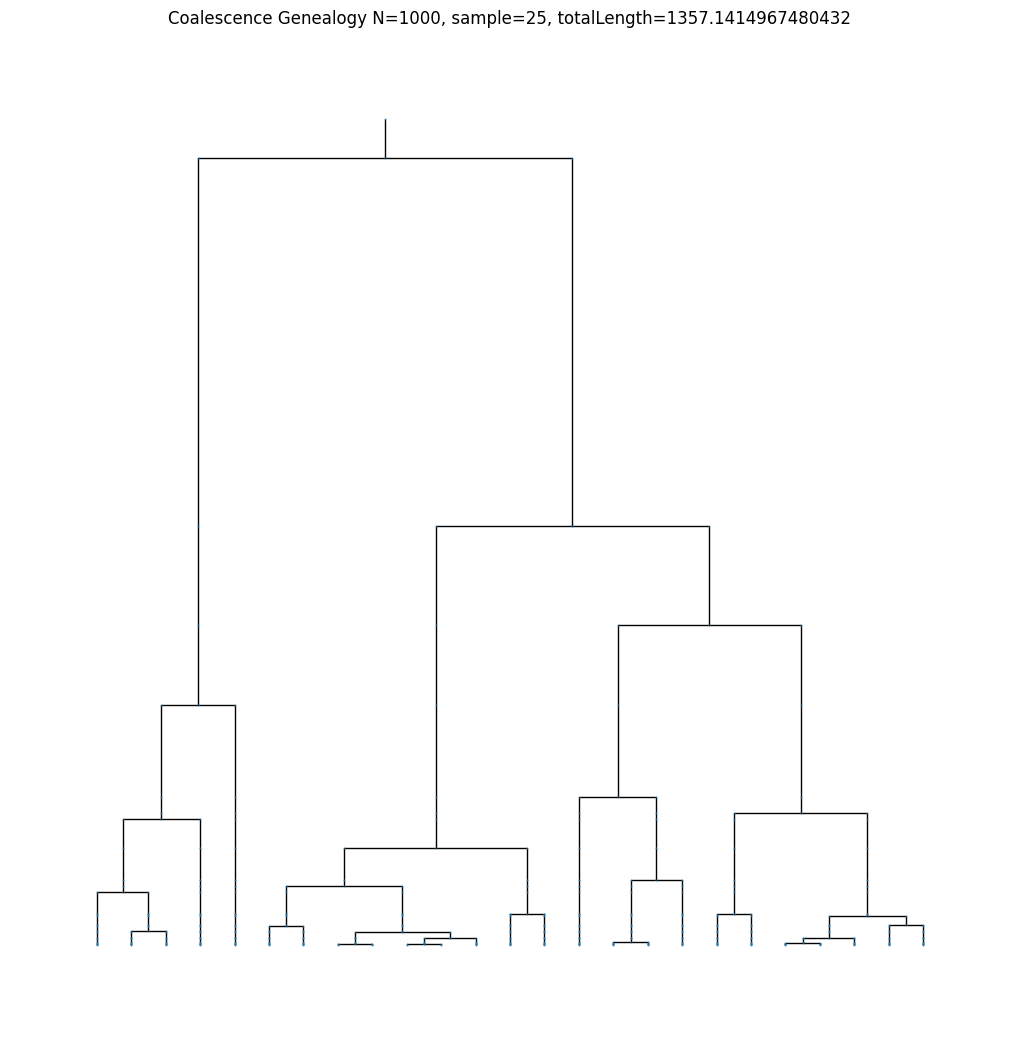

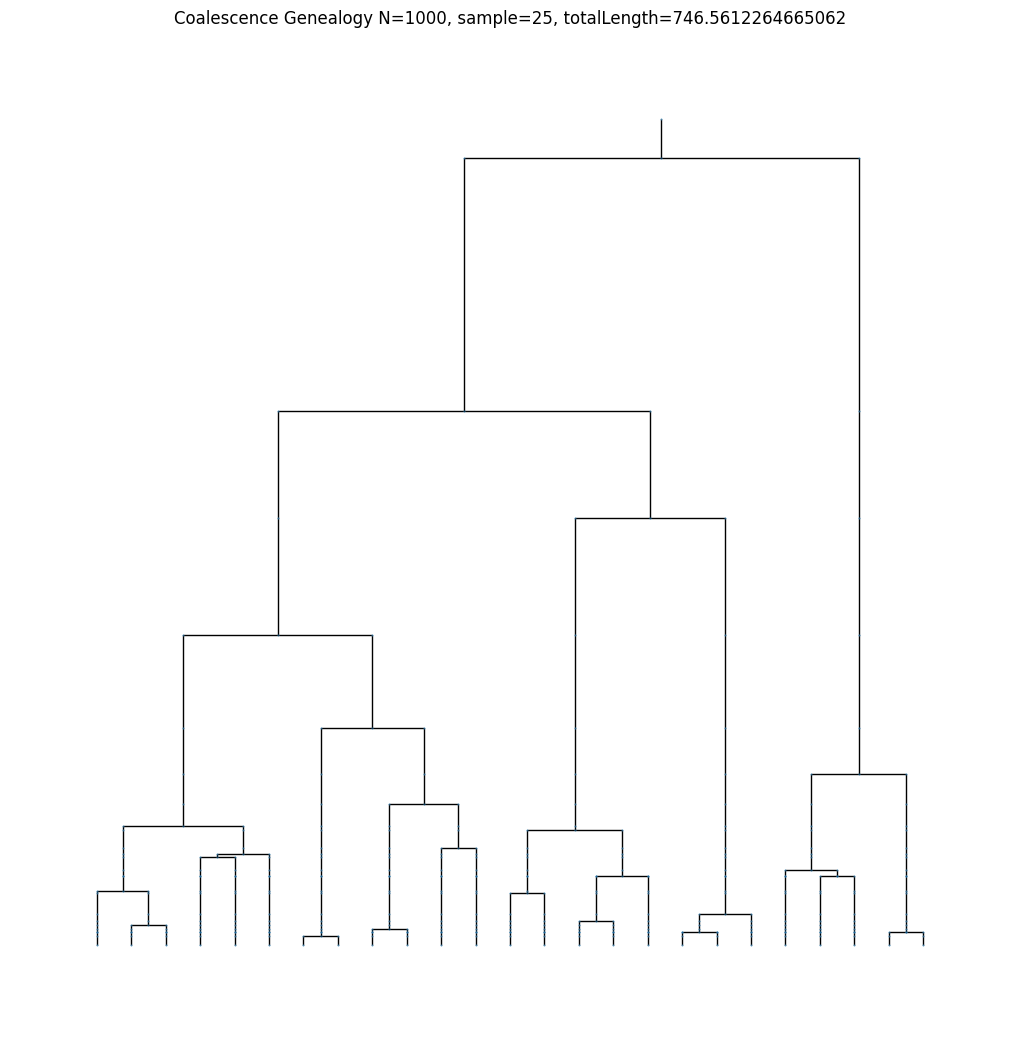

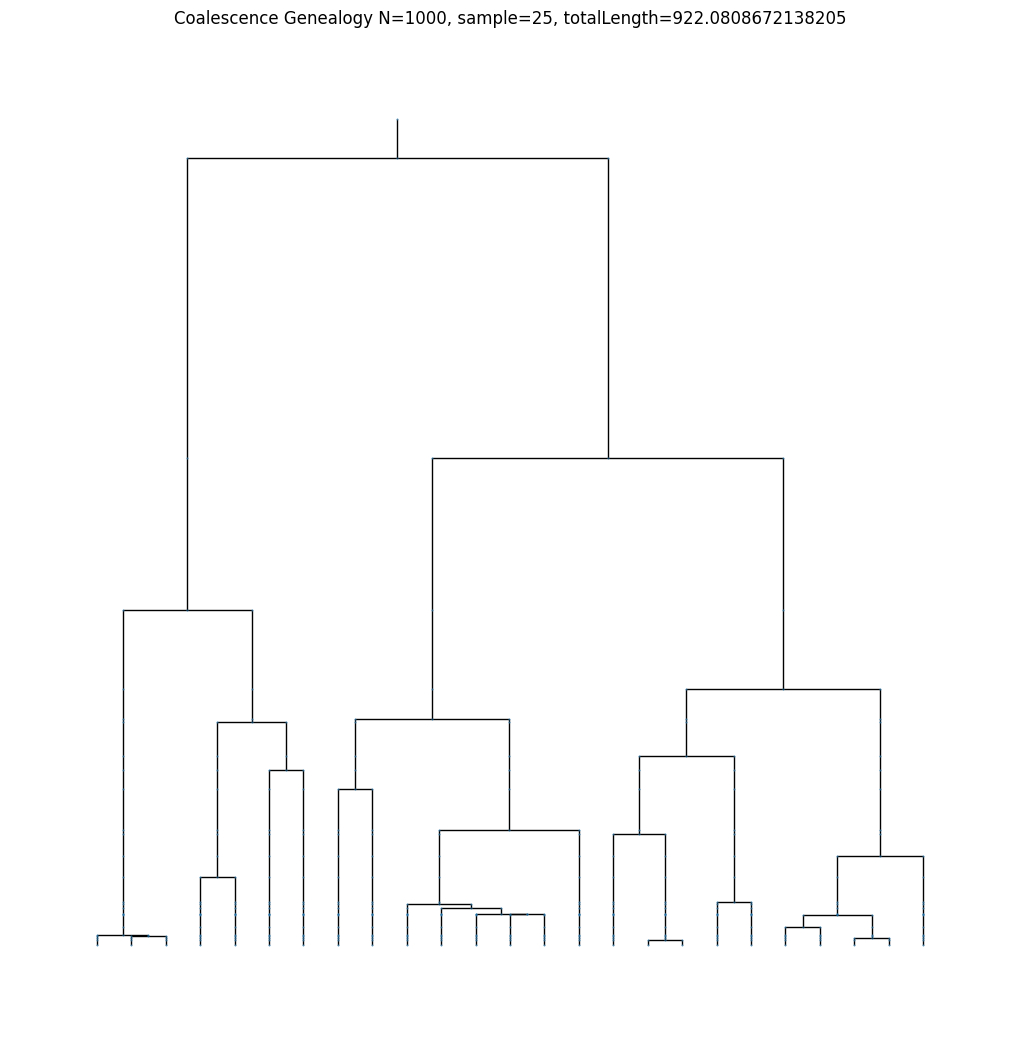

In [6]:
for j in range(2,15):
  exp=expo_samples(25,1000)
  draw_graph(graph_coalescence_new_version(exp), xaxis=10, yaxis=10, title=f"Coalescence Genealogy N={1000}, sample={25}, totalLength={sum(exp)}")